Signal length: 1000
Corner frequency: 5000.00 Hz


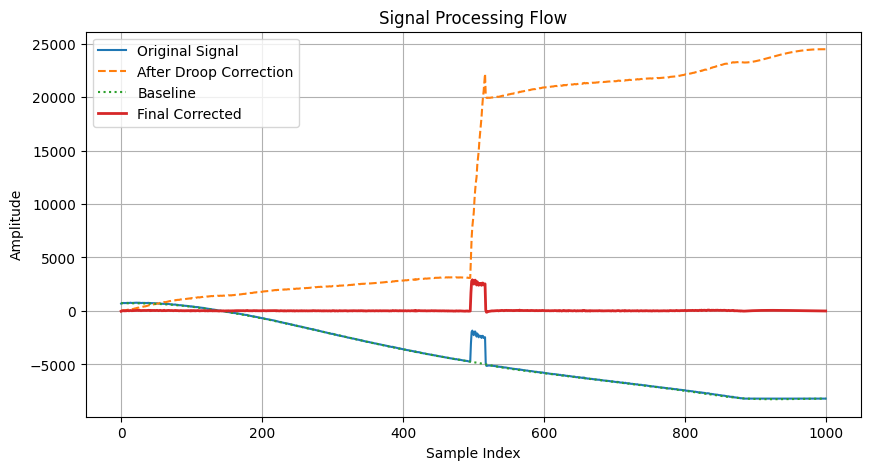

{'current': 2799.8612}
L:D0TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


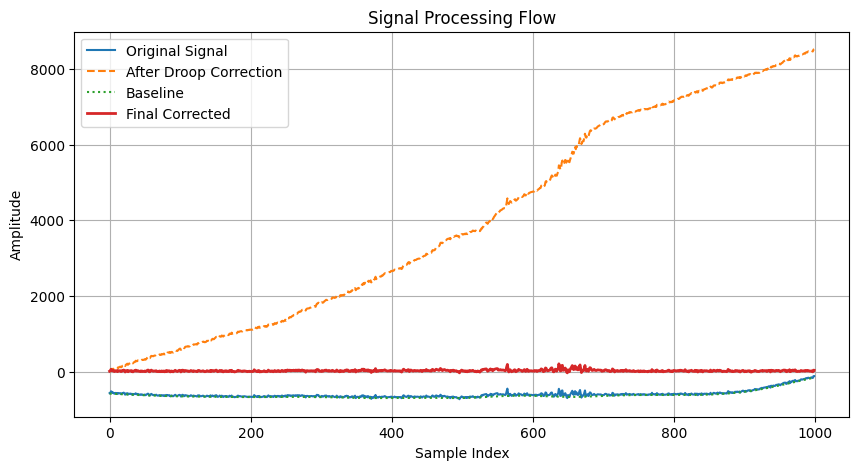

{'current': 200.6943}
L:D1TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


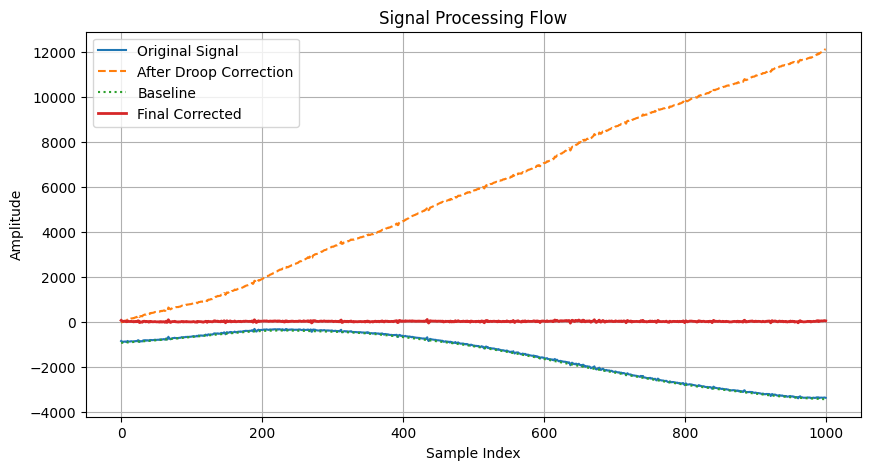

{'current': 116.303}
L:D2TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


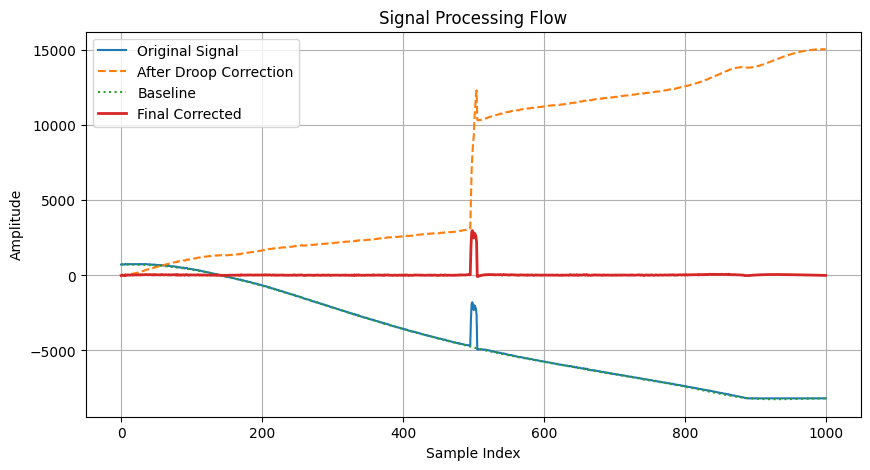

{'current': 2848.0313}
L:D3TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


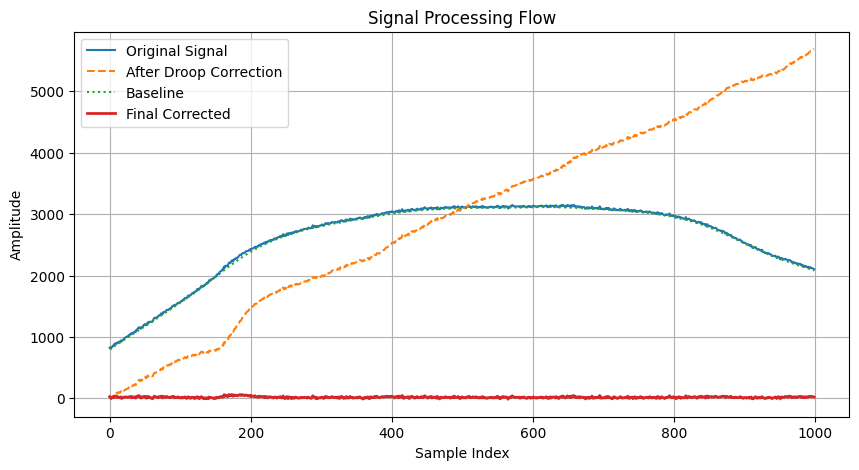

{'current': 60.7212}
L:D4TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


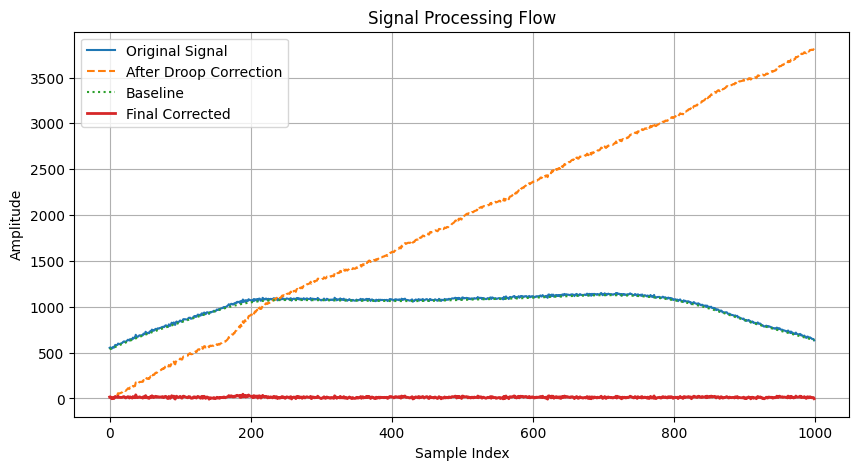

{'current': 46.1121}
L:D5TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


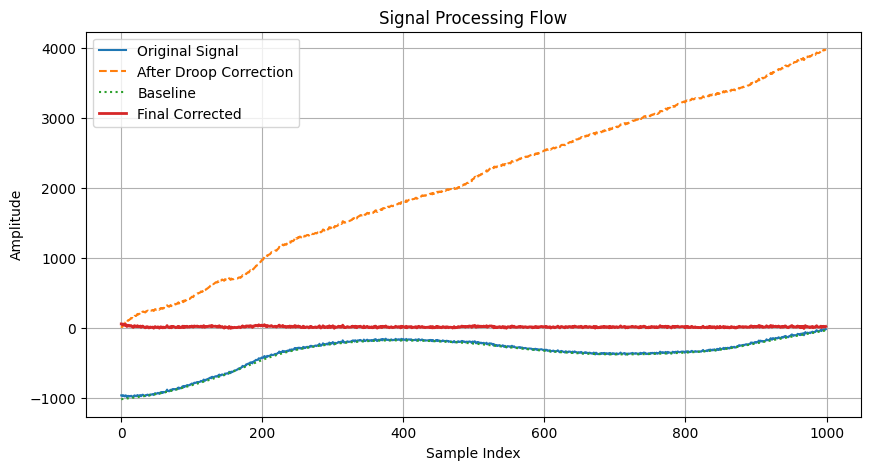

{'current': 54.2742}
L:D6TOR
Signal length: 1000
Corner frequency: 5000.00 Hz


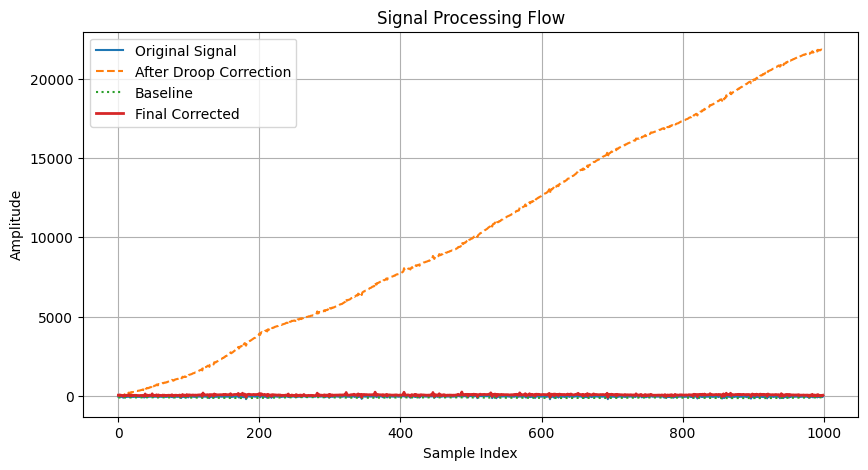

{'current': 245.2606}


In [ ]:
import json
import numpy as np
from scipy import sparse
from scipy.integrate import cumulative_trapezoid
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the baseline using Asymmetric Least Squares Smoothing (ALS)
def als_baseline(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.T)
        A = Z.tocsr()
        z = spsolve(A, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def als_baseline_corrected(z):
    baseline = als_baseline(z)
    corrected = z - baseline
    return {
        'corrected': json.dumps(corrected.tolist())
    }

def squarify(y):
    _, corrected, peak_value, left_index, right_index = get_prereqs(y)
    corrected[left_index:right_index + 1] = peak_value
    corrected[right_index:] = 0
    corrected[:left_index] = 0
    return {
        'squarified': json.dumps(corrected.tolist())
    }
    

def width(y):
    left, right = get_prereqs(y)[3:]
    return {
        'width': right - left
    }


def current(y, sampling_rate=5_000_000, f_corner=250, peak_fraction=0.9):
    corrected = get_prereqs(y, sampling_rate, f_corner)[1]

    peak_index = np.argmax(corrected)
    peak_value = corrected[peak_index]
    threshold = peak_fraction * peak_value

    # Define top region: points above threshold
    top_indices = np.where(corrected >= threshold)[0]

    if len(top_indices) == 0:
        raise ValueError("No values found above threshold; check pulse shape or threshold level.")

    avg_current = np.mean(corrected[top_indices])
    # pulse_width = len(top_indices)
    # total_charge = avg_current * pulse_width / sampling_rate  # A × s = Coulombs

    return {
        'current': round(float(avg_current), 4),
        # 'duration': round(pulse_width / sampling_rate, 6),  # in seconds
        # 'charge': round(total_charge, 6),  # in Coulombs
    }


def intensity(y):
    _, corrected, _, left_index, right_index = get_prereqs(y)
    my_range = right_index - left_index
    ten_percent = int(my_range * 0.1)
    start = max(left_index - ten_percent, 0)
    end = min(right_index + ten_percent, len(corrected))

    y_slice = corrected[start:end]
    x_vals = np.arange(len(y_slice))

    area = np.trapezoid(y=y_slice, x=x_vals)
    return {
        'intensity': round(float(area), 3)  # ensure clean Redis output
    }


def mode_filter(signal, window_size=3):
    s = pd.Series(signal)
    filtered = s.rolling(window=window_size, center=True, min_periods=1)\
                .apply(lambda x: x.mode().iloc[0])
    return filtered.to_numpy()




def get_prereqs(y, sampling_rate=5_000_000, f_corner=4000):
    # smoothed = mode_filter(y, window_size=5)
    baseline = als_baseline(y, lam=1e4, niter=10)
    corrected = y - baseline

    dt = 1 / sampling_rate  # 1 kHz sample rate

    # FFT
    n = len(corrected)
    freqs = np.fft.rfftfreq(n, dt)
    fft_mag = np.abs(np.fft.rfft(corrected))
    fft_mag /= np.max(fft_mag)  # normalize

    # Corner frequency at -3 dB
    corner_idx = np.where(fft_mag <= 1 / np.sqrt(2))[0][0]
    corner_freq = freqs[corner_idx]
    print(f"Corner frequency: {corner_freq:.2f} Hz")



    peak_index = np.argmax(corrected)
    peak_value = corrected[peak_index]
    half_max = 0.5 * peak_value

    left_index = peak_index
    while left_index > 0 and corrected[left_index] > half_max:
        left_index -= 1

    right_index = peak_index
    while right_index < len(corrected) - 1 and corrected[right_index] > half_max:
        right_index += 1

    # droop = droop_correct(corrected, left_index, sampling_rate, corner_freq)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y, label='Original Signal')
    # plt.plot(droop, label='After Droop Correction', linestyle='--')
    # plt.plot(smoothed, label='Mode Filtered', linestyle='-.')
    plt.plot(baseline, label='Baseline', linestyle=':')
    plt.plot(corrected, label='Final Corrected', linewidth=2)
    # plt.axvline(x=left_index, color='r', linestyle='--', label='Left Index')
    # plt.axvline(x=right_index, color='g', linestyle='--', label='Right Index')
    # plt.axhline(y=peak_value, color='orange', linestyle='--', label='Peak Value')
    plt.title('Signal Processing Flow')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()
    return baseline, corrected, peak_value, left_index, right_index




def droop_correct(y, left, right, sampling_rate=5_000_000, f_corner=250):
    dt = 1 / sampling_rate
    droop_const = 2 * np.pi * f_corner

    # Cumulative integral of the signal
    integral = cumulative_trapezoid(y, dx=dt, initial=0)

    # Apply correction
    corrected = y + droop_const * integral

    # Optional: shift to start near 0
    corrected -= np.min(corrected)

    return corrected


def extract_signal_from_binary(fields):
    """Extracts the first binary field and converts it into a NumPy array of int16."""
    for value in fields.values():
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
                return data
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue
    raise ValueError("No valid binary signal data found in stream entry.")


def measure(r, in_key, callback, out_key):
    """Continuously stream from Redis using XREAD and apply a processing callback."""
    last_id = '$'  # '$' starts from new entries
    while True:
        print("Listening for data...")
        entries = r.xread({in_key: last_id}, block=1000, count=1)
        if entries:
            print("Got entries...")
            for stream_name, messages in entries:
                for msg_id, fields in messages:
                    try:
                        y = extract_signal_from_binary(fields)  # <- updated to binary
                        result = callback(y)  # Must return a dictionary
                        r.xadd(out_key, result, maxlen=10)
                        last_id = msg_id  # move forward in the stream
                        print(f"Processed entry {msg_id} from {in_key}")
                    except Exception as e:
                        print(f"Error processing entry {msg_id}: {e}")


def process_pulse(y):
    baseline, corrected, peak_value, left_index, right_index = get_prereqs(y)

    flattened = corrected.copy()
    flattened[left_index:right_index + 1] = peak_value
    flattened[:left_index] = 0
    flattened[right_index:] = 0
    rectified = flattened + baseline

    pulse_width = int(right_index - left_index)
    current = peak_value
    intensity = current * pulse_width

    return {
        'signal': json.dumps(rectified.tolist()),
        'current': round(current, 4),
        'intensity': round(intensity, 4),
        'width': pulse_width
    }







if __name__ == "__main__":
    bin = "\xb9\x02\xde\x02\xe4\x02\xe5\x02\xed\x02\xdd\x02\xe9\x02\xe1\x02\xf2\x02\xf1\x02\xf9\x02\xe2\x02\xee\x02\x02\x03\xf4\x02\xeb\x02\xee\x02\xf9\x02\xf2\x02\x00\x03\xf6\x02\xfe\x02\x05\x03\xf8\x02\a\x03\xf1\x02\x03\x03\xfb\x02\xe1\x02\xea\x02\xf6\x02\xec\x02\xf4\x02\xf0\x02\xe3\x02\xe7\x02\xe6\x02\xf0\x02\xeb\x02\xf5\x02\xec\x02\xcd\x02\xeb\x02\xd3\x02\xdb\x02\xd4\x02\xd5\x02\xd9\x02\xc6\x02\xc7\x02\xcb\x02\xd2\x02\xbe\x02\xb0\x02\xb4\x02\xc4\x02\xbe\x02\xa6\x02\x9a\x02\xa2\x02\x95\x02\xb7\x02\x98\x02\x89\x02\x8d\x02\x8c\x02\x92\x02\x90\x02\x85\x02\x81\x02r\x02r\x02m\x02\\\x02Q\x02R\x02J\x02[\x02<\x02B\x029\x02.\x02\x19\x02\x1b\x02&\x02\x1b\x02\x06\x02\x02\x02\xfe\x01\xf3\x01\xe7\x01\xe7\x01\xdf\x01\xda\x01\xd3\x01\xd1\x01\xc7\x01\xb3\x01\xb4\x01\x91\x01\xb5\x01\xa1\x01\x86\x01\x9d\x01\x81\x01h\x01x\x01h\x01m\x01k\x01K\x013\x01=\x01.\x011\x01$\x01\x1b\x01\x1d\x01\t\x01\xef\x00\xed\x00\xea\x00\xde\x00\xc2\x00\xca\x00\xbe\x00\xb6\x00\xb2\x00\xa7\x00\x90\x00\x7f\x00\x84\x00z\x00d\x00e\x00W\x00@\x00A\x00+\x00\x11\x00 \x00\x12\x00\x01\x00\xec\xff\xf1\xff\xec\xff\xd3\xff\xce\xff\xc9\xff\xbc\xff\xb2\xff\x9c\xff\xa7\xff\x8a\xff\x87\xff{\xff\\\xfff\xff_\xffS\xff>\xffC\xff8\xff.\xff\n\xff\x1c\xff\x0f\xff\x00\xff\xeb\xfe\xe7\xfe\xd8\xfe\xcc\xfe\xc4\xfe\xbf\xfe\xae\xfe\x9d\xfe\x8b\xfe\x94\xfe\x86\xfe\x8a\xfea\xfeU\xfeQ\xfeD\xfe'\xfe \xfe\x0b\xfe\x12\xfe\b\xfe\x01\xfe\xeb\xfd\xce\xfd\xd3\xfd\xbb\xfd\xac\xfd\xa1\xfd\x9a\xfd\x8a\xfd\x80\xfdk\xfdX\xfda\xfdO\xfd@\xfd2\xfd\x1d\xfd\a\xfd\x05\xfd\xf8\xfc\xe8\xfc\xd7\xfc\xd7\xfc\xc0\xfc\xae\xfc\xa3\xfc\x97\xfc\x90\xfcz\xfcs\xfcg\xfc<\xfcF\xfc.\xfc\x1b\xfc\x0c\xfc\xf6\xfb\xff\xfb\xe8\xfb\xda\xfb\xc4\xfb\xb7\xfb\x96\xfb\xa4\xfb\x88\xfbn\xfbk\xfbe\xfbW\xfb8\xfb8\xfb,\xfb\x18\xfb\x0b\xfb\xed\xfa\xe8\xfa\xe5\xfa\xb6\xfa\xb3\xfa\xb7\xfa\xa5\xfa\x89\xfaw\xfao\xfad\xfaU\xfa<\xfaE\xfa \xfa\x10\xfa\b\xfa\xfc\xf9\xe2\xf9\xdd\xf9\xcf\xf9\xb5\xf9\xa9\xf9\xa2\xf9\x94\xf9\x80\xf9o\xf9b\xf9H\xf9Y\xf9>\xf9%\xf9$\xf9\x02\xf9\xf8\xf8\xe5\xf8\xdb\xf8\xd0\xf8\xb5\xf8\xad\xf8\x9f\xf8\x82\xf8r\xf8o\xf8N\xf8T\xf87\xf8/\xf8!\xf8\t\xf8\xf7\xf7\xec\xf7\xe8\xf7\xd5\xf7\xb1\xf7\xac\xf7\x9c\xf7\xab\xf7\x90\xf7\x84\xf7T\xf7U\xf7N\xf7<\xf7\x1d\xf7\x13\xf7\x14\xf7\x11\xf7\xec\xf6\xe3\xf6\xcf\xf6\xc1\xf6\xb6\xf6\xb3\xf6\xa1\xf6\x93\xf6{\xf6r\xf6I\xf6G\xf6=\xf60\xf6\x19\xf6\x12\xf6\t\xf6\xe7\xf5\xf1\xf5\xe1\xf5\xcc\xf5\xc5\xf5\xad\xf5\x9b\xf5\x97\xf5~\xf5\x82\xf5d\xf5R\xf5Y\xf5@\xf5(\xf5)\xf5\x03\xf5\xfe\xf4\xf2\xf4\xce\xf4\xcd\xf4\xc3\xf4\xb2\xf4\xb3\xf4\x9b\xf4\x8a\xf4}\xf4v\xf4]\xf4\\\xf4K\xf40\xf4!\xf4#\xf4\x16\xf4\x03\xf4\xf0\xf3\xdd\xf3\xdc\xf3\xc9\xf3\xc3\xf3\xa7\xf3\xa2\xf3\x93\xf3\x86\xf3~\xf3g\xf3g\xf3Z\xf3<\xf35\xf3\"\xf3\x03\xf3\x02\xf3\xf9\xf2\xe2\xf2\xdb\xf2\xec\xf2\xcf\xf2\xb3\xf2\xb2\xf2\xac\xf2\x8e\xf2\x8a\xf2p\xf2c\xf2N\xf2\\\xf28\xf22\xf2\x1e\xf2\x12\xf2\n\xf2\xee\xf1\xef\xf1\xe7\xf1\xcd\xf1\xb7\xf1\xb8\xf1\xaf\xf1\x9b\xf1\x89\xf1v\xf1q\xf1r\xf1Z\xf1S\xf13\xf1C\xf1\r\xf12\xf1\xfa\xf0\xff\xf0\xf0\xf0\xfb\xf0\xe4\xf0\xcf\xf0\xc1\xf0\xaf\xf0\xa1\xf0\x93\xf0\x82\xf0}\xf0}\xf0`\xf0O\xf0K\xf0=\xf0/\xf0!\xf0\x1c\xf0\x0c\xf0\x0f\xf0\xf7\xef\xe9\xef\xe4\xef\xc4\xef\xcc\xef\xbb\xef\xb0\xef\x9f\xef\x91\xef\x87\xefq\xefu\xef_\xefN\xefN\xef<\xef2\xef/\xef\x12\xef\r\xef\x03\xef\xf7\xee\xdc\xee\xe5\xee\xce\xee\xc5\xee\xbb\xee\xb1\xee\xa9\xee\x98\xee}\xee~\xeep\xee\\\xeeq\xeeY\xeeI\xeeH\xee+\xee7\xee)\xee\x16\xee\x13\xee\x06\xee\xf2\xed\xe9\xed\xdb\xed\xc7\xed\xd0\xed\xbe\xed\xbf\xed\x9f\xed\x97\xed\x90\xed\x87\xed\x1f\xf4[\xf8\xd4\xf8\a\xf8)\xf7i\xf8\x82\xf8\xcf\xf7\xa4\xf6\xc8\xf7%\xf7b\xf6\a\xf7\xd2\xf6\xe7\xf6)\xf6\xe9\xf6\xdf\xf6*\xf6\x1c\xf6k\xf6\xd1\xec\xf1\xeb\xf7\xeb\x0c\xec\x15\xec\x10\xec\x0c\xec\x0f\xec\x0f\xec\x0c\xec\xf8\xeb\xf1\xeb\xe0\xeb\xdb\xeb\xd9\xeb\xd8\xeb\xcb\xeb\xc3\xeb\x9f\xeb\xa0\xeb\xa4\xeb\x90\xeb\x9b\xeb\x93\xeb\x83\xebi\xebR\xebi\xebY\xebW\xebM\xeb1\xeb3\xeb,\xeb\x16\xeb\x14\xeb\n\xeb\xff\xea\xed\xea\xd7\xea\xe9\xea\xc8\xea\xcc\xea\xcf\xea\xbd\xea\xba\xea\xa5\xea\x99\xea\xb9\xea\x91\xea\x81\xea\x86\xeas\xeae\xea_\xeaV\xeaZ\xeaG\xea:\xeaC\xea%\xea#\xea\x17\xea\a\xea\x11\xea\b\xea\x06\xea\xf2\xe9\xe4\xe9\xd0\xe9\xd4\xe9\xbd\xe9\xcd\xe9\xbb\xe9\xa5\xe9\xa9\xe9\xa8\xe9\x8d\xe9\x90\xe9\x81\xe9\x8f\xe9}\xe9p\xe9j\xe9X\xe9G\xe9F\xe99\xe97\xe92\xe9\x1c\xe9\x18\xe9\x0f\xe9\x05\xe9\a\xe9\xf9\xe8\xeb\xe8\xf4\xe8\xeb\xe8\xda\xe8\xd8\xe8\xb6\xe8\xba\xe8\xc5\xe8\x97\xe8\xad\xe8\xaa\xe8\x81\xe8u\xe8\x84\xe8\x98\xe8i\xe8v\xe8c\xe8C\xe8T\xe8R\xe8,\xe8H\xe8?\xe8*\xe8\"\xe8\x0f\xe8\x04\xe8\x00\xe8\a\xe8\x05\xe8\xea\xe7\xd1\xe7\xd2\xe7\xdf\xe7\xc4\xe7\xc4\xe7\xbc\xe7\xb2\xe7\xad\xe7\xa1\xe7\x88\xe7\xb3\xe7\x93\xe7\xa5\xe7k\xe7^\xe7u\xe7W\xe7E\xe7R\xe7R\xe7#\xe76\xe71\xe7-\xe7\x17\xe7\x17\xe7\x0c\xe7\xfa\xe6\xfe\xe6\xfa\xe6\xf3\xe6\xde\xe6\xe5\xe6\xe9\xe6\xd0\xe6\xcb\xe6\xb6\xe6\xbe\xe6\xa6\xe6\xa0\xe6\x9c\xe6\x8b\xe6\x90\xe6\x83\xe6\x8c\xe6t\xe6s\xe6m\xe6Z\xe6W\xe6?\xe6E\xe6T\xe61\xe6+\xe6#\xe6\x10\xe6\x12\xe6\x10\xe6\x1b\xe6\r\xe6\t\xe6\xe0\xe5\xd9\xe5\xd7\xe5\xda\xe5\xdd\xe5\xce\xe5\xc4\xe5\xa4\xe5\xc8\xe5\xa7\xe5\x9e\xe5\x9d\xe5\x8e\xe5\x97\xe5\x8f\xe5q\xe5c\xe5g\xe5e\xe5V\xe5R\xe5J\xe5>\xe5;\xe5-\xe5A\xe5\x1c\xe5\x05\xe5\r\xe5\x0c\xe5\a\xe5\x03\xe5\xe9\xe4\xe6\xe4\xdf\xe4\xdb\xe4\xc5\xe4\xd5\xe4\xc7\xe4\xb9\xe4\xaa\xe4\x9f\xe4\x9f\xe4\x8e\xe4\x92\xe4w\xe4k\xe4}\xe4u\xe4^\xe4W\xe4K\xe4?\xe4L\xe4@\xe4%\xe4\"\xe4\x1b\xe4\x1d\xe4\x10\xe4\x02\xe4\x04\xe4\xfd\xe3\xf2\xe3\xeb\xe3\xe5\xe3\xd3\xe3\xc7\xe3\xcd\xe3\xb0\xe3\xad\xe3\xc1\xe3\xb2\xe3\x9d\xe3\x92\xe3\x8e\xe3\x89\xe3\x82\xe3l\xe3k\xe3{\xe3m\xe3P\xe3J\xe3D\xe3/\xe38\xe31\xe3&\xe3 \xe3\x0f\xe3\b\xe3\x10\xe3\t\xe3\xe0\xe2\xe0\xe2\xe3\xe2\xdb\xe2\xcf\xe2\xc7\xe2\xbe\xe2\xb9\xe2\xa8\xe2\xae\xe2\x9f\xe2\x99\xe2}\xe2\x88\xe2w\xe2j\xe2f\xe2E\xe2O\xe2R\xe2L\xe23\xe2E\xe2\x17\xe2\"\xe2\x1c\xe2\x10\xe2\x0c\xe2\xe9\xe1\xd5\xe1\xf1\xe1\xf6\xe1\xe7\xe1\xde\xe1\xb7\xe1\xb1\xe1\xb9\xe1\x9e\xe1\xa6\xe1\x94\xe1\x87\xe1{\xe1\x80\xe1k\xe1r\xe1a\xe1S\xe1D\xe1E\xe1=\xe1,\xe1\x1f\xe1\x1d\xe1\x1d\xe1\x10\xe1\a\xe1\xf3\xe0\xeb\xe0\xca\xe0\xc9\xe0\xd7\xe0\xc9\xe0\xab\xe0\xa8\xe0\x9d\xe0\xaa\xe0\xa2\xe0\xa3\xe0r\xe0s\xe0g\xe0e\xe0a\xe0Y\xe0C\xe0?\xe0<\xe0\x1e\xe0+\xe0\x1d\xe0\x10\xe0\n\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0"
    bin = bin.encode('latin-1')  # Convert to bytes
    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D0TOR
    print("L:D0TOR")
    bin = "\xca\xfd\xd2\xfd\xfc\xfd\xed\xfd\xd0\xfd\xdc\xfd\xc3\xfd\xbb\xfd\xd0\xfd\xcf\xfd\xcd\xfd\xb5\xfd\xd0\xfd\xc5\xfd\xc7\xfd\xcb\xfd\xb4\xfd\xb5\xfd\xce\xfd\xc9\xfd\xd8\xfd\xc4\xfd\xa2\xfd\xc1\xfd\xc1\xfd\xca\xfd\xa6\xfd\xbd\xfd\xb8\xfd\xbb\xfd\xbe\xfd\xab\xfd\xb7\xfd\x9c\xfd\xb0\xfd\xb5\xfd\xb1\xfd\xc7\xfd\xad\xfd\xab\xfd\xb7\xfd\xac\xfd\xa1\xfd\x9f\xfd\xab\xfd\xa0\xfd\xa8\xfd\x9c\xfd\x9b\xfd\xa1\xfd\xa5\xfd\x94\xfd\xa2\xfd\xb3\xfd\xbc\xfd\xb9\xfd\x8f\xfd\x8c\xfd\xa5\xfd\xb7\xfd\xa9\xfd\x9d\xfd\x95\xfd\x9c\xfd\x9b\xfd\x97\xfd\xa2\xfd\x90\xfd\x8a\xfd\x88\xfd\x93\xfd\x97\xfd\x85\xfd\x89\xfd\x98\xfd\x89\xfd\x88\xfd\x96\xfd~\xfd\x85\xfd\x9c\xfd\x84\xfd\x9a\xfd\x93\xfd\x8c\xfd\x95\xfdw\xfd\x80\xfd\x8f\xfd\x80\xfdx\xfd\x86\xfd\x91\xfd\x9f\xfd\x8c\xfd\x87\xfd|\xfd\x8b\xfd\x97\xfd\x9d\xfd\x98\xfdq\xfd~\xfd\x9e\xfd\x9d\xfd\x85\xfd{\xfd\x94\xfd\x93\xfd\x8c\xfd\x87\xfd\x89\xfdy\xfdz\xfd\x82\xfd\x92\xfd\x8d\xfd\x83\xfdw\xfd\x8b\xfd\x82\xfd\x81\xfd~\xfdx\xfdq\xfd\x8f\xfd\x86\xfd\x90\xfd\x84\xfdw\xfdz\xfd\x7f\xfd\x86\xfd\x85\xfdt\xfdm\xfdr\xfdw\xfd\x89\xfd~\xfd}\xfdr\xfd|\xfd\x90\xfdo\xfd\x85\xfd\x8c\xfdy\xfdv\xfd\x87\xfd\x8b\xfd\x95\xfd\x88\xfdi\xfdm\xfds\xfd\x8b\xfd|\xfdq\xfd\x89\xfdv\xfdc\xfdx\xfdw\xfd~\xfdo\xfd}\xfdr\xfdh\xfdl\xfd\x87\xfdv\xfdq\xfd\x8b\xfdi\xfdl\xfdm\xfd_\xfdc\xfdh\xfdl\xfdz\xfd\x8a\xfdu\xfdy\xfd|\xfdu\xfdq\xfdi\xfdw\xfds\xfdy\xfdu\xfdo\xfdn\xfdd\xfdm\xfdi\xfdq\xfdh\xfdl\xfdj\xfdf\xfdi\xfdo\xfd\x97\xfd\x82\xfdw\xfdi\xfdd\xfd~\xfdl\xfd\x80\xfd^\xfdk\xfdb\xfdi\xfdk\xfdq\xfd~\xfdu\xfdd\xfdp\xfdc\xfds\xfd\x90\xfd{\xfdv\xfdi\xfdz\xfdw\xfdy\xfde\xfdq\xfd\x87\xfdz\xfdi\xfdv\xfd\x82\xfdu\xfd\x83\xfdq\xfdh\xfd{\xfd\x8a\xfd\x88\xfdo\xfdw\xfdz\xfd\x8d\xfdm\xfd\x80\xfd\x96\xfd\x91\xfd\x85\xfd\x91\xfd\x8f\xfd|\xfd\x88\xfd\x8e\xfd\x86\xfd\x91\xfd\x87\xfd\x7f\xfd\x93\xfd\x8e\xfd~\xfd\x94\xfd\x8e\xfd\x93\xfd\x82\xfd\x7f\xfd\x8e\xfd\x95\xfd\x8b\xfd}\xfd\x87\xfdz\xfdZ\xfd~\xfd\x83\xfd~\xfdx\xfdv\xfd~\xfdy\xfd\x7f\xfd}\xfdt\xfd{\xfd\x7f\xfdt\xfdb\xfd\x8c\xfd\x9f\xfd\x92\xfd\x98\xfdx\xfdn\xfdo\xfdk\xfd\x82\xfdo\xfdq\xfd}\xfd\x88\xfd\x86\xfd\x8c\xfdz\xfdu\xfd{\xfdn\xfdz\xfdr\xfdo\xfdl\xfd\x83\xfdv\xfdn\xfda\xfdg\xfdh\xfd\x88\xfdp\xfdh\xfdi\xfdW\xfdy\xfdb\xfdm\xfdc\xfdi\xfd\\\xfdl\xfd}\xfdu\xfd\x86\xfd{\xfd~\xfd]\xfdY\xfdf\xfd^\xfdp\xfdw\xfdZ\xfd^\xfdy\xfd\x87\xfdH\xfd`\xfdh\xfdj\xfd[\xfdk\xfdt\xfdc\xfdx\xfd\x90\xfds\xfd\x8f\xfdc\xfd~\xfdb\xfdj\xfdy\xfd\\\xfdy\xfdY\xfd[\xfdk\xfd4\xfd\\\xfd_\xfdN\xfdo\xfdh\xfd\x9b\xfdN\xfdf\xfdZ\xfdW\xfdj\xfdj\xfdf\xfd_\xfdo\xfdc\xfdm\xfdq\xfd|\xfdt\xfdf\xfda\xfd]\xfd`\xfdb\xfdf\xfd]\xfdo\xfdi\xfd^\xfd]\xfd`\xfdp\xfd^\xfd_\xfdd\xfdc\xfda\xfdd\xfd^\xfde\xfdX\xfdF\xfd^\xfd\x86\xfd\x92\xfd~\xfdr\xfdk\xfde\xfdt\xfd\x85\xfd\x86\xfdT\xfdj\xfd~\xfdt\xfdj\xfdb\xfdb\xfds\xfdq\xfdf\xfdi\xfdo\xfdm\xfdi\xfdb\xfde\xfdv\xfdk\xfdU\xfdl\xfdt\xfdq\xfdl\xfdi\xfd\x8b\xfdm\xfdl\xfdq\xfdi\xfdd\xfdb\xfd_\xfd\x82\xfd\x8d\xfds\xfdl\xfdi\xfd\x80\xfd\x8e\xfd\x87\xfd|\xfdz\xfdn\xfd{\xfd\xa1\xfd\x91\xfdt\xfdg\xfd|\xfd\x80\xfd\x83\xfdr\xfdi\xfdo\xfdr\xfdj\xfdb\xfdf\xfdF\xfdc\xfdj\xfdd\xfdr\xfdW\xfd`\xfd]\xfda\xfd_\xfdG\xfdH\xfdM\xfd*\xfdS\xfd_\xfdt\xfdk\xfdY\xfd^\xfdX\xfdb\xfdP\xfda\xfdL\xfdc\xfdd\xfdW\xfds\xfdi\xfdh\xfdo\xfdy\xfdi\xfdc\xfdZ\xfdh\xfdW\xfd[\xfdo\xfdc\xfd_\xfdS\xfdm\xfd\x8f\xfd\x84\xfd\x9d\xfd\x98\xfd\xa8\xfd\xa9\xfd\xad\xfd\xb3\xfd\x9b\xfdv\xfd\x95\xfd\x97\xfd\x94\xfd\xb8\xfd\xa5\xfd\xb0\xfd\x8a\xfd\x98\xfd\xb1\xfd\xb5\xfd\xbe\xfd\xc3\xfd\xc8\xfd\xc8\xfd\xa4\xfd\xa4\xfd\xa6\xfd\xb3\xfd\xaa\xfd\xa7\xfd\xa9\xfd\xac\xfd\xa6\xfd\x9f\xfd\x96\xfd\xb1\xfd\x00\xfeB\xfe\xbf\xfd}\xfd\xab\xfd\xb8\xfd\x99\xfd\x82\xfd\x92\xfd\x9c\xfd\x96\xfd\xba\xfd\xb4\xfd\x86\xfd\x92\xfd\x9e\xfd\xa8\xfd\xc6\xfd\xb4\xfd\xad\xfd\xad\xfd\xa5\xfd\x8f\xfd\x99\xfd\xa2\xfd\xc0\xfd\x9c\xfd\x8e\xfd\xb7\xfd\xc7\xfd\x9a\xfd\x8f\xfd\xa2\xfd\x9d\xfd\x9e\xfd\x9e\xfd\x98\xfd\x97\xfd\x99\xfd\x8f\xfd\xa1\xfd\x9c\xfd\xa0\xfd\x87\xfd\x95\xfd\x9e\xfd\x9e\xfd\xa8\xfd\x9c\xfd\xc9\xfd\xbf\xfd\xb3\xfd~\xfd\x87\xfd\x8e\xfd\xdd\xfd\xd4\xfd\xa0\xfd\x90\xfd\x93\xfd\x9b\xfd\x9c\xfd\xb8\xfd\xd7\xfd\xdb\xfd\xa7\xfds\xfdn\xfd\x9b\xfd\xb4\xfd\x91\xfd~\xfd\xad\xfd\xbe\xfd=\xfe\xf8\xfd\x81\xfd\x84\xfd\x0b\xfe\x12\xfe\x90\xfd\x8f\xfd\xa3\xfd\xca\xfd\xa2\xfdZ\xfdI\xfd\x9a\xfdu\xfdf\xfd\xa4\xfd\xc3\xfd\xe4\xfd\t\xfe\xb1\xfd\x9e\xfd\xe6\xfd\xff\xfd\xa8\xfd\xdf\xfd\xad\xfd\x99\xfd\xa2\xfd\xf6\xfd\x1d\xfe\xb3\xfdU\xfd\x90\xfd\x8d\xfd\x88\xfd\xd3\xfd\x12\xfe\x99\xfd\x81\xfd\xa2\xfd\xb0\xfd}\xfd\xbc\xfd\xde\xfd\xd6\xfd\xaf\xfd\x97\xfd\x99\xfd\xa6\xfd\xb6\xfd\x9f\xfd\x9c\xfd\x98\xfd\xa1\xfd\xac\xfd\xab\xfd\xa8\xfd\xa6\xfd\xa9\xfd\xa5\xfd\x8a\xfd\x94\xfd\x96\xfd\x98\xfd\xb0\xfd\xb8\xfd\xb6\xfd\xa6\xfd\x9b\xfd\xa3\xfd\xa9\xfd\x8a\xfd\x95\xfd\x91\xfd\x9e\xfd\xd4\xfd\xc7\xfd\xa0\xfd\x87\xfd\xa7\xfd\xa5\xfd\xaa\xfd\x9d\xfd\xa8\xfd\x9f\xfd\xa0\xfd\xaa\xfd\xa1\xfd\xb3\xfd\xb5\xfd\x9a\xfd\xae\xfd\xaa\xfd\xad\xfd\xcb\xfd\xa0\xfd\xa9\xfd\xaa\xfd\xab\xfd\xb5\xfd\xa3\xfd\xa9\xfd\xa4\xfd\x9e\xfd\xaf\xfd\xb6\xfd\xa0\xfd\x9b\xfd\xa1\xfd\xa5\xfd\xa7\xfd\xae\xfd\xb1\xfd\x99\xfd\x9f\xfd\xb3\xfd\xa5\xfd\xa0\xfd\xad\xfd\xa5\xfd\xaf\xfd\xa1\xfd\xa5\xfd\xa0\xfd\xa0\xfd\x99\xfd\xa9\xfd\xa6\xfd\xac\xfd\xa6\xfd\x9b\xfd\xd4\xfd\xab\xfd\xae\xfd\xaa\xfd\xa9\xfd\xb6\xfd\x99\xfd\xca\xfd\xb9\xfd\xae\xfd\xa1\xfd\xa7\xfd\xa0\xfd\xae\xfd\xa7\xfd\xba\xfd\x97\xfd\xa2\xfd\xa2\xfd\xa1\xfd\xa7\xfd\xa7\xfd\xb1\xfd\xc1\xfd\xc3\xfd\xa5\xfd\xa7\xfd\xae\xfd\x9d\xfd\xaf\xfd\xa2\xfd\xba\xfd\xb9\xfd\xb3\xfd\xa9\xfd\xb0\xfd\xad\xfd\xba\xfd\xab\xfd\xaf\xfd\xc2\xfd\xbb\xfd\xbf\xfd\xb3\xfd\xab\xfd\xa6\xfd\xa9\xfd\xcf\xfd\xb3\xfd\xa2\xfd\xa7\xfd\xab\xfd\x95\xfd\xb4\xfd\xb0\xfd\xb6\xfd\xc1\xfd\xaf\xfd\xa6\xfd\xa6\xfd\xa6\xfd\xc1\xfd\xa6\xfd\xb9\xfd\xbd\xfd\x95\xfd\xaf\xfd\xba\xfd\xac\xfd\xa7\xfd\xc4\xfd\xbd\xfd\x9b\xfd\xb0\xfd\xbd\xfd\xba\xfd\xb7\xfd\xbe\xfd\xbb\xfd\xb4\xfd\xb4\xfd\xaa\xfd\xab\xfd\xd3\xfd\xba\xfd\xab\xfd\xb7\xfd\xcf\xfd\xd3\xfd\xc6\xfd\xc3\xfd\xba\xfd\xc9\xfd\xd9\xfd\xcb\xfd\xc5\xfd\xdb\xfd\xd7\xfd\xc9\xfd\xca\xfd\xb8\xfd\xc3\xfd\xca\xfd\xc4\xfd\xc8\xfd\xc5\xfd\xc0\xfd\xda\xfd\x00\xfe\xf1\xfd\xd6\xfd\xe2\xfd\xda\xfd\xd2\xfd\xe2\xfd\xd3\xfd\xd3\xfd\xde\xfd\xf1\xfd\xe3\xfd\xee\xfd\xf5\xfd\xe9\xfd\xe7\xfd\xf6\xfd\xda\xfd\xea\xfd\xfa\xfd\x02\xfe\r\xfe\x03\xfe\xed\xfd\x00\xfe\x06\xfe\xf6\xfd\x06\xfe\x11\xfe\x16\xfe\x0f\xfe\x19\xfe\xfd\xfd\xfe\xfd\x12\xfe\x18\xfe!\xfe%\xfe9\xfe2\xfe3\xfe&\xfe.\xfe+\xfe-\xfe?\xfeI\xfeN\xfeW\xfeH\xfeW\xfe_\xfe_\xfe`\xfek\xfeV\xfef\xfez\xfe\x80\xfe\x7f\xfe]\xfe\x8f\xfe\x89\xfe\x81\xfe\x93\xfe\x8c\xfe\x88\xfe\x8e\xfe\xa5\xfe\xa1\xfe\xac\xfe\xa7\xfe\xb4\xfe\xaa\xfe\x9a\xfe\xaf\xfe\xbd\xfe\xc1\xfe\xd3\xfe\xdb\xfe\xdd\xfe\xe1\xfe\xc4\xfe\xbf\xfe\xe4\xfe\xe0\xfe\xdf\xfe\a\xff\xd6\xfe\xf9\xfe\xf1\xfe\t\xff\x12\xff\x03\xff\x17\xff&\xff\x05\xff\r\xff\x04\xff\x12\xff\x17\xff\x13\xff\x1b\xff4\xff7\xff0\xff5\xff>\xffB\xff;\xffS\xffV\xffO\xff_\xffb\xffW\xff\\\xff`\xffl\xffb\xffZ\xff\x8b\xff\x8c\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))



    # L:D1TOR
    print("L:D1TOR")
    bin = "\xbe\xfc\xa3\xfc\xa5\xfc\x95\xfc\xa1\xfc\xa6\xfc\xac\xfc\x97\xfc\x95\xfc\xc3\xfc\xb1\xfc\xa7\xfc\xaa\xfc\xaa\xfc\xb8\xfc\xb3\xfc\xa9\xfc\xb2\xfc\xa4\xfc\xb6\xfc\xba\xfc\xb1\xfc\xc5\xfc\xbc\xfc\xe4\xfc\xda\xfc\x96\xfc\xb9\xfc\xb7\xfc\xb5\xfc\xaf\xfc\xd8\xfc\xdc\xfc\xe3\xfc\xde\xfc\xcc\xfc\xe3\xfc\xdb\xfc\xe2\xfc\xca\xfc\xd1\xfc\xf1\xfc\xde\xfc\xed\xfc\xe9\xfc\xe5\xfc\xed\xfc\xee\xfc\xfc\xfc\xf3\xfc\xf0\xfc\xf5\xfc\xf8\xfc\xf7\xfc\xf1\xfc\a\xfd\xfc\xfc\r\xfd\xfd\xfc\a\xfd\x13\xfd\x0f\xfd\xfd\xfc\x0e\xfd6\xfd\x00\xfd\x14\xfd}\xfdD\xfd\"\xfd\x0c\xfd-\xfd1\xfdA\xfd>\xfdJ\xfdR\xfd>\xfdF\xfdA\xfdC\xfd>\xfdN\xfdN\xfdO\xfd^\xfdm\xfdd\xfdY\xfdn\xfdf\xfdk\xfd{\xfdl\xfdz\xfdw\xfdw\xfd|\xfd{\xfd~\xfd\x85\xfd\x87\xfd\x95\xfd\x9c\xfd\x8e\xfd\x88\xfd\x8e\xfd\xa5\xfd\x8c\xfd\xa6\xfd\xb8\xfd\xb0\xfd\xb0\xfd\xb8\xfd\xaf\xfd\xb5\xfd\xa7\xfd\xab\xfd\xc2\xfd\xcb\xfd\xdc\xfd\xc3\xfd\xb0\xfd\xdf\xfd\xe8\xfd\xd9\xfd\xda\xfd\xe7\xfd\xe1\xfd\xdc\xfd\xe6\xfd\x01\xfe\x13\xfe\x04\xfe\x12\xfe\x01\xfe\n\xfe\x15\xfe\xff\xfd\a\xfe\x04\xfe\x02\xfe(\xfe!\xfe\x12\xfe\x1a\xfeC\xfe,\xfe\xeb\xfd\x1f\xfeL\xfe.\xfe+\xfe=\xfeJ\xfeR\xfe(\xfeB\xfe?\xfeA\xfeI\xfeb\xfeJ\xfeA\xfeO\xfeR\xfe_\xfe_\xfeZ\xfei\xfeV\xfe^\xfee\xfek\xfez\xfen\xfe\x84\xfe\x82\xfe\x80\xfe}\xfex\xfe}\xfe\x87\xfe\x83\xfe\x86\xfe\x97\xfe\x9e\xfei\xfe\x93\xfe\xd9\xfe\xb6\xfeq\xfee\xfe\x8f\xfe\xa9\xfe\xb7\xfe\x98\xfe\xa2\xfe\xac\xfe\xab\xfe\xa8\xfe\xab\xfe\xbb\xfe\xbe\xfe\xb8\xfe\xb8\xfe\xc7\xfe\xbb\xfe\xb7\xfe\xad\xfe\xb2\xfe\xc3\xfe\xbe\xfe\xba\xfe\xbf\xfe\xb5\xfe\xc8\xfe\xc2\xfe\xcc\xfe\xc9\xfe\xc0\xfe\xba\xfe\xcb\xfe\xbc\xfe\xc9\xfe\xcc\xfe\xb7\xfe\xba\xfe\xb0\xfe\xca\xfe\xb4\xfe\xa0\xfe\x9d\xfe\xcf\xfe\xb8\xfe\xcd\xfe\xac\xfe\xa9\xfe\xbc\xfe\xb4\xfe\xbe\xfe\xb4\xfe\xc5\xfe\xbd\xfe\xbd\xfe\xac\xfe\xb3\xfe\xb1\xfe\xb8\xfe\xaf\xfe\xb4\xfe\xab\xfe\xc3\xfe\xbe\xfe\xbe\xfe\xae\xfe\xa7\xfe\xae\xfe\xb3\xfe\xc3\xfe\xab\xfe\xa8\xfe\xae\xfe\xae\xfe\xb0\xfe\xc0\xfe\x99\xfe\x8f\xfe\xb9\xfe\xc1\xfeY\xfeh\xfe\xbb\xfe\xbc\xfe\xae\xfe\xb8\xfe\xa6\xfe\x9c\xfe\x99\xfe\x93\xfe\x8f\xfe\x97\xfe\x9e\xfe\x9e\xfe\xa2\xfe\x8f\xfe\x97\xfe\x9a\xfe\xa5\xfe\x97\xfe\x8e\xfe\x90\xfe\x96\xfe\x88\xfe\x97\xfe\x8e\xfe\x8f\xfe\x8b\xfe\x92\xfe\x95\xfe\x85\xfeu\xfe\x82\xfe\x7f\xfe\x89\xfe}\xfeq\xfe{\xfe\x7f\xfeg\xfe|\xfe\x9f\xfe\xb3\xfeF\xfeI\xfe]\xfew\xfev\xfeq\xfe^\xfen\xfem\xfeW\xfe_\xfei\xfei\xfet\xfe[\xfeN\xfeU\xfe@\xfeR\xfeI\xfeQ\xfeF\xfeB\xfeJ\xfe?\xfeH\xfeI\xfeF\xfe5\xfe;\xfe=\xfe4\xfe8\xfe!\xfe9\xfe2\xfeF\xfe\"\xfe:\xfe\x16\xfe\x0f\xfe\x1a\xfe\x1e\xfe\x15\xfe\x06\xfe\x1a\xfe\x12\xfe \xfe\x1e\xfe\x06\xfe\x06\xfe\x11\xfe\r\xfe\xf4\xfd\x06\xfe\x06\xfe\xfd\xfd\x12\xfe\xff\xfd\xec\xfd\xd8\xfd\xf3\xfd\xf9\xfd\xed\xfd\xe8\xfd\xeb\xfd\xd2\xfd\xdc\xfd\xcc\xfd\xcd\xfd\xd3\xfd\xc9\xfd\xcb\xfd\xb6\xfd\xce\xfd\xcb\xfd\xc4\xfd\xd5\xfd\xce\xfdx\xfd~\xfd\xc8\xfd\xd0\xfd\xba\xfd\x9d\xfd\xa8\xfd\xab\xfd\x91\xfd\x94\xfd\x92\xfd\xa4\xfd\x8d\xfd\x8e\xfd\x8d\xfd\x85\xfd\x83\xfd\x89\xfdz\xfdz\xfdg\xfdz\xfdm\xfde\xfdc\xfdT\xfdZ\xfdM\xfdN\xfdQ\xfdA\xfdK\xfd?\xfd<\xfd7\xfd.\xfd/\xfd2\xfd\x1a\xfd,\xfd,\xfd#\xfdf\xfd\xf1\xfc\xc0\xfc\xe5\xfc\x1f\xfd\x17\xfd\t\xfd\x04\xfd\x01\xfd\xf9\xfc\xf5\xfc\xf2\xfc\xf6\xfc\xe5\xfc\xda\xfc\xe3\xfc\xde\xfc\xdb\xfc\xd5\xfc\xd5\xfc\xc1\xfc\xca\xfc\xc8\xfc\xa0\xfc\xa1\xfc\xa6\xfc\xb5\xfc\xa3\xfc\xa9\xfc\xa2\xfc\x9c\xfc\xa0\xfc{\xfc\xa1\xfc\x8c\xfco\xfc\x84\xfcs\xfch\xfc\x80\xfc\x93\xfce\xfce\xfcv\xfc\x81\xfca\xfc[\xfcH\xfcK\xfcO\xfc@\xfcQ\xfcC\xfc4\xfc+\xfc=\xfc+\xfc7\xfc\x1a\xfc\x15\xfc\x14\xfc\xf2\xfb!\xfc\x12\xfc\x0b\xfc\xf4\xfb\xf6\xfb\xf4\xfb\xed\xfb\xda\xfb\xeb\xfb\xe3\xfb\xd6\xfb\xe4\xfb\xc4\xfb\xb0\xfb\xc2\xfb\xd9\xfb\xc8\xfb\xc6\xfb\x90\xfbr\xfb\xb1\xfb\xc6\xfb\xc7\xfb\x99\xfb\xb2\xfb\x89\xfb\x80\xfb\x8a\xfb\x87\xfbx\xfbl\xfbw\xfbr\xfbr\xfb_\xfb^\xfb[\xfbB\xfb;\xfbZ\xfbF\xfb0\xfb7\xfb$\xfb\x1c\xfb)\xfb$\xfb\r\xfb\x13\xfb\x05\xfb\x0c\xfb\x1c\xfb\xfd\xfa\xf8\xfa\xed\xfa\xd8\xfa\xce\xfa\xed\xfa\xcb\xfa\xd5\xfa\xfb\xfa\xbe\xfa\x94\xfa\xb2\xfa\xc3\xfa\xc2\xfa\xb3\xfa\xc5\xfa\xa5\xfa\x95\xfa\x8c\xfau\xfaq\xfa\x92\xfa\x8d\xfan\xfa\x82\xfa\x84\xfaT\xfad\xfaX\xfab\xfaV\xfaD\xfaC\xfa;\xfa7\xfa.\xfa6\xfa;\xfa&\xfa&\xfa\xff\xf9\x1a\xfa\x19\xfa\xf1\xf9\x02\xfa\xeb\xf9\xb6\xf9\xe6\xf9\xe8\xf9\xea\xf9\xda\xf9\xdc\xf9\xd0\xf9\xb9\xf9\xb2\xf9\xc0\xf9\xc6\xf9\xa2\xf9\xa1\xf9\x9c\xf9\x98\xf9\x99\xf9\x8f\xf9\x80\xf9\x8b\xf9f\xf9\x82\xf9\xa4\xf9i\xf9u\xf9\x83\xf9_\xf9M\xf97\xf9M\xf9N\xf9D\xf9/\xf98\xf9,\xf9#\xf9+\xf9&\xf9\x12\xf9\x1d\xf9\x03\xf9\x01\xf9\x11\xf9\xe5\xf8\x8b\xf8\xc5\xf8\xfa\xf8\xf8\xf8\xd3\xf8\xbe\xf8\xcc\xf8\xb3\xf8\xd5\xf8\xc2\xf8\xac\xf8\xb6\xf8\xcf\xf8\x9e\xf8\x97\xf8\x96\xf8g\xf8\x91\xf8\xa7\xf8g\xf8\x7f\xf8I\xf8O\xf8a\xf8_\xf8A\xf8O\xf8T\xf88\xf8\b\xf8\x15\xf8+\xf8,\xf8<\xf8Z\xf8\x15\xf8\xe2\xf7\xd2\xf7\xf1\xf7\x01\xf8\xf0\xf7 \xf8\xe9\xf7\xbb\xf7\xc6\xf7\xdb\xf7\xf4\xf7\xdf\xf7\xaf\xf7\x96\xf7\xad\xf7\xbb\xf7\xa0\xf7\xa6\xf7\x9d\xf7\xa8\xf7\x97\xf7\x8c\xf7\x96\xf7\x91\xf7o\xf7k\xf7j\xf7c\xf7z\xf7f\xf7[\xf7L\xf7G\xf7U\xf7A\xf79\xf7F\xf7-\xf7\x1e\xf73\xf7/\xf7#\xf7\r\xf7\xcd\xf6\x14\xf7)\xf7\x06\xf7\xf7\xf6\xf1\xf6\xf4\xf6\xf1\xf6\xbd\xf6\xce\xf6\xc4\xf6\xcc\xf6\xbf\xf6\xbb\xf6\xbb\xf6\xb6\xf6\xa8\xf6\xa8\xf6\x9a\xf6\x8f\xf6\x89\xf6\xb5\xf6\x9e\xf6\x8d\xf6\xaf\xf6n\xf6k\xf6l\xf6f\xf6O\xf6T\xf6M\xf6W\xf6J\xf6_\xf6<\xf6@\xf6I\xf6,\xf6+\xf6!\xf67\xf6\r\xf6\xeb\xf5\a\xf6<\xf6)\xf6\x00\xf6\xf5\xf5\xf7\xf5\xed\xf5\xe3\xf5\xe8\xf5\xe3\xf5\xd6\xf5\xce\xf5\xd7\xf5\xdc\xf5\xc0\xf5\xa8\xf5\xa4\xf5\x93\xf5\xc1\xf5\xb2\xf5\x9c\xf5\x99\xf5\xa5\xf5\x9f\xf5\x9e\xf5\x8c\xf5\x91\xf5\x87\xf5{\xf5\x87\xf5n\xf5j\xf5y\xf5c\xf5c\xf5i\xf5]\xf5v\xf5Q\xf5\x1a\xf5V\xf5d\xf58\xf5-\xf55\xf57\xf5A\xf5>\xf5;\xf54\xf5'\xf5\x1f\xf5\x1c\xf5\x14\xf5\x0f\xf5\x0b\xf5\xed\xf4\xea\xf4\x01\xf5\x19\xf5\xf9\xf4\x01\xf5\xf8\xf4\xdf\xf4\xe5\xf4\xe8\xf4\xe6\xf4\xdb\xf4\xc7\xf4\xc9\xf4\xc1\xf4\xcc\xf4\xba\xf4\xac\xf4\xc0\xf4\xc4\xf4\xb5\xf4\xad\xf4w\xf4\xb1\xf4\xd6\xf4\xbe\xf4\x9b\xf4\xa2\xf4\x9a\xf4\x97\xf4\x8b\xf4\x8a\xf4\x96\xf4\x8d\xf4|\xf4o\xf4v\xf4{\xf4d\xf4k\xf4_\xf4W\xf4h\xf4[\xf4S\xf4T\xf4:\xf49\xf48\xf44\xf4-\xf48\xf4;\xf44\xf47\xf4/\xf4%\xf4\x15\xf4-\xf4%\xf4\x05\xf4\x1a\xf4\b\xf4\x0c\xf4\a\xf4\xee\xf3\xec\xf3*\xf44\xf4\x03\xf4\xde\xf3\xe7\xf3\xdf\xf3\xec\xf3\xdf\xf3\xee\xf3\xe7\xf3\xeb\xf3\xe2\xf3\xea\xf3\xd3\xf3\xca\xf3\xbe\xf3\xcb\xf3\xcf\xf3\xb8\xf3\xb7\xf3\xbb\xf3\xb7\xf3\xaf\xf3\xab\xf3\xa2\xf3\x93\xf3\x93\xf3\xa5\xf3\x8f\xf3\x8b\xf3\x7f\xf3\x8c\xf3\x93\xf3\x86\xf3\x93\xf3\x8d\xf3\x8f\xf3\x80\xf37\xf3W\xf3\x92\xf3w\xf3h\xf3s\xf3u\xf3p\xf3V\xf3S\xf3B\xf3K\xf3]\xf3[\xf3H\xf3>\xf3N\xf3I\xf30\xf33\xf39\xf3&\xf36\xf3\x1b\xf3\x17\xf3#\xf3%\xf3\x16\xf37\xf3\x1e\xf3!\xf3*\xf3\x18\xf3\x1c\xf3\xfa\xf2\x01\xf3\t\xf3\xfe\xf2\x06\xf3\xd0\xf2\xf9\xf2 \xf3&\xf3\xfc\xf2\xfa\xf2\xfa\xf2\xed\xf2\xe8\xf2\xeb\xf2\xe9\xf2\xed\xf2\xec\xf2\xf7\xf2\xf6\xf2\xeb\xf2\xf3\xf2\xf0\xf2\xd5\xf2\xe1\xf2\xe2\xf2\xea\xf2\xee\xf2\xe0\xf2\xe5\xf2\xe3\xf2\xf9\xf2\xfb\xf2\xdc\xf2\xfb\xf2\xd9\xf2\xeb\xf2\xed\xf2\xef\xf2\xea\xf2\xe8\xf2\xed\xf2\xf4\xf2\xf0\xf2\xe6\xf2"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))

    # L:D2TOR
    print("L:D2TOR")
    bin = "\xd3\x02\xdf\x02\xf0\x02\xd7\x02\xd1\x02\xd0\x02\xfe\x02\xe2\x02\xd7\x02\xe5\x02\xf9\x02\xf1\x02\xdc\x02\xec\x02\xef\x02\xf0\x02\xe1\x02\xe7\x02\xf4\x02\xe6\x02\xef\x02\xea\x02\xe7\x02\xed\x02\xe6\x02\xf7\x02\xee\x02\xee\x02\xde\x02\xf2\x02\xed\x02\xed\x02\xe6\x02\xef\x02\xee\x02\xf2\x02\xf0\x02\xdf\x02\xda\x02\xe5\x02\xda\x02\xe4\x02\xda\x02\xd3\x02\xc5\x02\xba\x02\xd9\x02\xcc\x02\xb3\x02\xc5\x02\xc3\x02\xb5\x02\xb6\x02\xb3\x02\xae\x02\xa0\x02\xae\x02\xa1\x02\xb4\x02\x9e\x02\x91\x02\x8f\x02\x97\x02\x8c\x02\x8d\x02\x84\x02\x80\x02m\x02\x7f\x02m\x02e\x02Y\x02e\x02_\x02[\x02W\x02S\x02J\x02/\x02G\x02\x1e\x02/\x02\x1b\x02!\x02\x01\x02\x0e\x02\xfd\x01\xfc\x01\x04\x02\xfb\x01\xd5\x01\xd5\x01\xed\x01\xf5\x01\xd5\x01\xb6\x01\xab\x01\xbe\x01\xb3\x01\xac\x01\xa1\x01\x95\x01\x91\x01\x8d\x01\x80\x01x\x01b\x01o\x01j\x01Y\x01T\x015\x019\x01:\x01%\x01\x11\x01\x11\x01\t\x01\xfe\x00\xf8\x00\xe4\x00\xe2\x00\xcc\x00\xce\x00\xca\x00\xbf\x00\xa7\x00\x95\x00\x99\x00\x8e\x00\x7f\x00w\x00o\x00d\x00Z\x00G\x00T\x00,\x00-\x00 \x00\x1c\x00\t\x00\xf5\xff\xf5\xff\xdb\xff\xe1\xff\xc1\xff\xcb\xff\xb4\xff\xa6\xff\xa6\xff\x98\xff\x87\xff\x90\xff\x80\xfft\xffi\xff`\xffN\xffE\xff>\xff0\xff#\xff\x17\xff\x0f\xff\n\xff\t\xff\xe2\xfe\xe2\xfe\xee\xfe\xc4\xfe\xd6\xfe\xc3\xfe\xb0\xfe\xa1\xfe\x99\xfe\x90\xfe|\xfex\xfes\xfeY\xfeW\xfeE\xfeD\xfe1\xfe$\xfe\x11\xfe\x04\xfe\xfa\xfd\xf4\xfd\xdd\xfd\xe2\xfd\xcb\xfd\xbc\xfd\xac\xfd\xa3\xfd\x9d\xfd\x8b\xfd\x82\xfds\xfdg\xfd[\xfdM\xfd>\xfd@\xfd\x1f\xfd#\xfd\b\xfd\xf2\xfc\xf3\xfc\xe7\xfc\xdd\xfc\xc1\xfc\xa3\xfc\xa5\xfc\xa1\xfc\x86\xfc\x83\xfca\xfce\xfcQ\xfc-\xfc3\xfc,\xfc\x12\xfc\x02\xfc\xf9\xfb\xed\xfb\xe7\xfb\xca\xfb\xc8\xfb\xac\xfb\x9a\xfb\x8a\xfb\x88\xfbt\xfbg\xfbO\xfbJ\xfb@\xfb'\xfb\x1b\xfb\x0f\xfb\x02\xfb\xe9\xfa\xf5\xfa\xe4\xfa\xbd\xfa\xba\xfa\x99\xfa\x92\xfa\x95\xfa\x80\xfao\xfai\xfaR\xfaR\xfa5\xfa\x11\xfa\xfd\xf9\xf9\xf9\xe4\xf9\xe5\xf9\xce\xf9\xc2\xf9\xbb\xf9\xa7\xf9\xa2\xf9\x81\xf9x\xf9o\xf9R\xf9D\xf94\xf97\xf9\x17\xf9\t\xf9\x04\xf9\x05\xf9\xe3\xf8\xc8\xf8\xc5\xf8\xba\xf8\x98\xf8\x92\xf8\x97\xf8t\xf8t\xf8Z\xf8T\xf82\xf83\xf8\x15\xf8\x17\xf8\r\xf8\xfd\xf7\xd4\xf7\xc1\xf7\xc1\xf7\xb4\xf7\xa6\xf7\x98\xf7\x94\xf7y\xf7o\xf7Z\xf7L\xf7@\xf7:\xf7$\xf7\x10\xf7\xf8\xf6\xf4\xf6\xe9\xf6\xd6\xf6\xc7\xf6\xb9\xf6\xa6\xf6\xad\xf6\x87\xf6w\xf6k\xf6b\xf6H\xf6C\xf6$\xf6\x1f\xf6#\xf6\xff\xf5\xf8\xf5\xd6\xf5\xf6\xf5\xcf\xf5\xb5\xf5\xc0\xf5\x9a\xf5\x97\xf5\x9f\xf5x\xf5f\xf5O\xf5>\xf59\xf5,\xf5 \xf5\x04\xf5\xf6\xf4\xfb\xf4\xe7\xf4\xdf\xf4\xc1\xf4\xc0\xf4\xad\xf4\x98\xf4\x85\xf4z\xf4}\xf4b\xf4p\xf4I\xf4;\xf4.\xf4!\xf4\x13\xf4\x0f\xf4\xf4\xf3\xf8\xf3\xd8\xf3\xd0\xf3\xba\xf3\xb5\xf3\x95\xf3\x83\xf3\x99\xf3x\xf3m\xf3a\xf3V\xf3P\xf3.\xf3/\xf3\x11\xf3\xfd\xf2\xfa\xf2\xea\xf2\xcf\xf2\xc8\xf2\xc2\xf2\xbe\xf2\xb2\xf2\x8c\xf2\x80\xf2~\xf2i\xf2d\xf2a\xf2B\xf2;\xf28\xf2\x14\xf2\x16\xf2\x03\xf2\xf0\xf1\x00\xf2\xdf\xf1\xdf\xf1\xc9\xf1\xa9\xf1\x96\xf1\x96\xf1\x92\xf1\x83\xf1a\xf1d\xf1c\xf1G\xf1M\xf1E\xf1/\xf1&\xf1\x1c\xf1\t\xf1\xfe\xf0\xeb\xf0\xe1\xf0\xce\xf0\xd1\xf0\xb9\xf0\xaf\xf0\x9e\xf0\x8c\xf0y\xf0x\xf0s\xf0f\xf0]\xf0E\xf09\xf0>\xf0 \xf0!\xf0\x00\xf0\xfd\xef\xfa\xef\xe9\xef\xe1\xef\xce\xef\xba\xef\xbb\xef\x9e\xef\x90\xef\x8a\xef\x83\xef\x8c\xefq\xefd\xef[\xef8\xef<\xefK\xef9\xef\x19\xef\xff\xee\x05\xef\xf6\xee\xed\xee\xe1\xee\xd3\xee\xcc\xee\xb8\xee\xb3\xee\xa8\xee\x93\xee\x95\xee{\xee|\xeei\xeeg\xeeb\xeeH\xeeS\xee>\xee)\xee+\xee\x1d\xee\x12\xee\x03\xee\xf1\xed\xe9\xed\xe0\xed\xe5\xed\xd0\xed\xcd\xed\xd0\xed\xb4\xed\x9d\xed\x94\xf4\x94\xf8\xff\xf8]\xf8\xf9\xf65\xf8\xd9\xf7\\\xf7\xc2\xf5\xb5\xec\xa6\xec\xc5\xec\xbd\xec\xbb\xec\xc1\xec\xb5\xec\xbe\xec\xb7\xec\xb6\xec\xaf\xec\xb0\xec\x99\xec\xa1\xec\x8b\xec\x87\xec\x84\xeck\xeco\xecc\xecH\xecJ\xecA\xec9\xec%\xec\x11\xec\x11\xec\x05\xec\xfb\xeb\xf8\xeb\xea\xeb\xd9\xeb\xd9\xeb\xdb\xeb\xc2\xeb\xa0\xeb\xa5\xeb\xb8\xeb\xa0\xeb\x97\xeb\x85\xeb\x81\xebp\xebf\xebT\xebQ\xeb9\xebF\xebE\xeb4\xeb-\xeb\x1f\xeb\x12\xeb\x03\xeb\xfc\xea\xf3\xea\xdc\xea\xdd\xea\xca\xea\xb4\xea\xc4\xea\xcb\xea\xb9\xea\xa6\xea\xa5\xea\x9b\xea\x89\xea\x8b\xeau\xeao\xeaa\xeaq\xeaN\xeaR\xeaA\xea6\xea:\xea5\xea.\xea\x13\xea\xfa\xe9\t\xea\x03\xea\xf2\xe9\xf6\xe9\xdf\xe9\xe0\xe9\xd4\xe9\xc9\xe9\xc6\xe9\xae\xe9\xa6\xe9\xb2\xe9\x9b\xe9\x98\xe9\x91\xe9\x8a\xe9\x8a\xe9~\xe9q\xe9V\xe9Z\xe9[\xe9I\xe9<\xe9;\xe97\xe9\x1d\xe9!\xe9\x14\xe9\x01\xe9\xfe\xe8\xf7\xe8\x02\xe9\xf0\xe8\xe5\xe8\xc7\xe8\xcc\xe8\xc7\xe8\xb4\xe8\xc2\xe8\xa8\xe8\xa6\xe8\x9b\xe8\x97\xe8\x89\xe8\x87\xe8\x87\xe8x\xe8e\xe8o\xe8S\xe8j\xe8e\xe8N\xe82\xe8+\xe8>\xe8$\xe8\x0f\xe8\x10\xe8(\xe8\n\xe8\xe0\xe7\xf1\xe7\xfd\xe7\xe7\xe7\xd9\xe7\xcb\xe7\xca\xe7\xcd\xe7\xd8\xe7\xc2\xe7\x99\xe7\xa5\xe7\xbb\xe7\xa0\xe7j\xe7w\xe7u\xe7f\xe7N\xe7Q\xe7_\xe7L\xe7B\xe7Q\xe7;\xe7-\xe71\xe7\x1d\xe7\n\xe7\x15\xe7\x0f\xe7\xf5\xe6\xf5\xe6\xed\xe6\xcd\xe6\xdd\xe6\xe5\xe6\xc7\xe6\xc4\xe6\xb6\xe6\xaf\xe6\xb3\xe6\x9f\xe6\x9d\xe6\x8b\xe6\x91\xe6\x7f\xe6w\xe6|\xe6^\xe6\\\xe6b\xe6Q\xe6U\xe67\xe65\xe6=\xe6'\xe6)\xe6\x1a\xe6\n\xe6\x14\xe6\x01\xe6\x02\xe6\xf3\xe5\xed\xe5\xe2\xe5\xe2\xe5\xd0\xe5\xce\xe5\xbf\xe5\xba\xe5\xb4\xe5\xa0\xe5\xa4\xe5\xa6\xe5\x90\xe5\x96\xe5\x82\xe5u\xe5j\xe5n\xe5e\xe5[\xe5W\xe5S\xe5L\xe5N\xe5.\xe5\x1f\xe5,\xe5$\xe5\x17\xe5\xee\xe4\xe7\xe4\xfc\xe4\xfa\xe4\xe8\xe4\xe9\xe4\xd3\xe4\xd5\xe4\xb9\xe4\xc2\xe4\xc5\xe4\xba\xe4\xb4\xe4\xa0\xe4\x8b\xe4\x82\xe4\x87\xe4\x91\xe4}\xe4n\xe4Y\xe4b\xe4W\xe4K\xe4Q\xe4A\xe43\xe4)\xe4!\xe4\"\xe4#\xe4\x11\xe4\x04\xe4\xfe\xe3\xf9\xe3\xf7\xe3\xe7\xe3\xf1\xe3\xd5\xe3\xca\xe3\xce\xe3\xc5\xe3\xcb\xe3\xa6\xe3\x8c\xe3\x97\xe3\x91\xe3\x8c\xe3x\xe3}\xe3y\xe3o\xe3l\xe3Z\xe3D\xe3E\xe3N\xe36\xe32\xe3\x11\xe3$\xe3 \xe3\xfe\xe2\xfb\xe2\xfa\xe2\xf7\xe2\xea\xe2\xd9\xe2\xd5\xe2\xcf\xe2\xca\xe2\xbb\xe2\xbe\xe2\xab\xe2\xa2\xe2\x99\xe2\x91\xe2\x94\xe2k\xe2u\xe2o\xe2g\xe2W\xe2\\\xe2E\xe2>\xe2*\xe29\xe2!\xe2*\xe2\n\xe2\x05\xe2\x0f\xe2\b\xe2\x00\xe2\xea\xe1\xe4\xe1\xe1\xe1\xce\xe1\xbb\xe1\xc8\xe1\xb5\xe1\xab\xe1\x9f\xe1\x9a\xe1\x82\xe1\x88\xe1{\xe1h\xe1d\xe1j\xe1[\xe1T\xe1A\xe16\xe1-\xe15\xe1#\xe1\x17\xe1\a\xe1\x1a\xe1\xf5\xe0\xf8\xe0\xe1\xe0\xe1\xe0\xd1\xe0\xbc\xe0\xc1\xe0\xc0\xe0\xae\xe0\xaa\xe0\x9d\xe0\x8c\xe0\x8c\xe0\x81\xe0o\xe0h\xe0b\xe0R\xe0P\xe0K\xe0;\xe0:\xe0\x1c\xe0\r\xe0\x11\xe0\r\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0\x00\xe0"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D3TOR
    print("L:D3TOR")
    bin = ":\x031\x03*\x03G\x03I\x03^\x03U\x03{\x03u\x03\x84\x03{\x03\x84\x03\x96\x03\x8d\x03\x99\x03\x9a\x03\xb0\x03\x9d\x03\xae\x03\xb9\x03\xc9\x03\xd1\x03\xdc\x03\xe3\x03\xec\x03\xeb\x03\xf4\x03\x02\x04\x0b\x04\x15\x04\x0f\x04%\x04\x1b\x040\x041\x042\x04E\x049\x04\\\x04[\x04q\x04\x81\x04\x86\x04t\x04n\x04\x8a\x04\x83\x04\x95\x04\xa4\x04\xb1\x04\xa7\x04\xbb\x04\xa8\x04\xbf\x04\xd5\x04\xc8\x04\xdc\x04\xdf\x04\xe0\x04\xdd\x04\xde\x04\xe3\x04\x01\x05\x1b\x05!\x05\x1d\x05$\x05'\x05+\x05@\x05@\x05L\x05Q\x05h\x05e\x05Z\x05z\x05\x81\x05z\x05~\x05\x95\x05\xa1\x05\x9d\x05\xa0\x05\xac\x05\xac\x05\xbe\x05\xbb\x05\xcb\x05\xdf\x05\xdf\x05\xed\x05\xde\x05\xf1\x05\xf7\x05\xf8\x05\n\x06\x16\x06\x11\x06\x14\x06\"\x06(\x06*\x06>\x06;\x06M\x06Y\x06d\x06`\x06Z\x06p\x06\x85\x06\x8c\x06\x84\x06\x87\x06\x97\x06\x9b\x06\xb1\x06\xb5\x06\xbe\x06\xb3\x06\xc9\x06\xcc\x06\xd5\x06\xf3\x06\xf4\x06\xf8\x06\xeb\x06\x04\a\x0b\a&\a\"\a(\a\x1e\a5\a0\a@\aQ\aL\a_\a[\a\x80\a{\a\x8b\a\x92\a\x98\a\x9e\a\x9d\a\xab\a\xbc\a\xb9\a\xc5\a\xdf\a\xde\a\xee\a\xef\a\n\b\x12\b\x1a\b\x1e\b2\b0\b_\bM\bo\bm\bq\bk\bx\b\xa0\b\xa2\b\x9c\b\xab\b\xc2\b\xc9\b\xb6\b\xcb\b\xdd\b\xd9\b\xe8\b\xf1\b\xed\b\xf9\b\n\t\x16\t$\t\x1c\t$\t9\t=\t?\t<\tK\tY\t\\\t`\t_\td\ts\t|\to\t\x85\t\x83\t\x8a\t\x8b\t\x95\t\xa5\t\x9b\t\x9f\t\xa4\t\xb1\t\xaa\t\xc4\t\xbe\t\xc7\t\xd1\t\xcf\t\xd6\t\xd8\t\xe8\t\xd7\t\xef\t\xf7\t\xf1\t\xeb\t\xff\t\x03\n\x0f\n\x11\n\x0e\n\x15\n\x15\n\x11\n%\n,\n,\n3\n(\n8\nA\nE\nB\nV\nM\nH\n\\\nq\nS\nf\nT\ne\nx\n~\na\n\x81\n\x80\n\x85\nt\n\x8c\n~\n\x85\n\x95\n\x89\n\x9e\n\xa1\n\x9b\n\xa3\n\x9c\n\xa0\n\xa3\n\xaa\n\xb8\n\xb1\n\xba\n\xbd\n\xbd\n\xc8\n\xc7\n\xc8\n\xcb\n\xc5\n\xd2\n\xdb\n\xd6\n\xd4\n\xd1\n\xd3\n\xe6\n\x02\x0b\xf4\n\xf1\n\xf7\n\xe1\n\xe4\n\xf7\n\xe6\n\xf0\n\xf7\n\xfe\n\xfb\n\x02\x0b\r\x0b\x0f\x0b\xfd\n\x03\x0b\n\x0b%\x0b\x1f\x0b\x18\x0b%\x0b\x17\x0b!\x0b\x1c\x0b$\x0b%\x0b6\x0b6\x0b3\x0b+\x0b-\x0b9\x0b3\x0b0\x0b1\x0bD\x0b7\x0b.\x0bK\x0bR\x0bK\x0bS\x0bE\x0b<\x0bF\x0bT\x0bE\x0bb\x0bW\x0bO\x0bO\x0b]\x0bo\x0b^\x0b^\x0bf\x0bZ\x0b]\x0bd\x0bh\x0bi\x0bm\x0bg\x0bv\x0b{\x0bw\x0b\x82\x0bu\x0bt\x0br\x0bf\x0bw\x0b\x84\x0by\x0b\x8a\x0b\x89\x0b\x84\x0b\x98\x0b\x94\x0b~\x0b\x83\x0b\xa1\x0b\x9c\x0b\x9e\x0b\x9b\x0b\xa6\x0b\x9d\x0b\xb2\x0b\xa7\x0b\xa9\x0b\xbc\x0b\xb4\x0b\xaf\x0b\xa9\x0b\xad\x0b\xb5\x0b\xb7\x0b\xc4\x0b\xc4\x0b\xc6\x0b\xc1\x0b\xc7\x0b\xcf\x0b\xd7\x0b\xd0\x0b\xcb\x0b\xd6\x0b\xd8\x0b\xdf\x0b\xd5\x0b\xdb\x0b\xe5\x0b\xdf\x0b\xdd\x0b\xde\x0b\xce\x0b\xdb\x0b\xe9\x0b\xeb\x0b\xe2\x0b\xd8\x0b\xf7\x0b\xe5\x0b\xf0\x0b\xea\x0b\xed\x0b\t\x0c\xe9\x0b\xdb\x0b\xe9\x0b\xf3\x0b\xf6\x0b\xf1\x0b\xf0\x0b\xff\x0b\xfd\x0b\xe2\x0b\xf8\x0b\x03\x0c\n\x0c\r\x0c\xff\x0b\xf9\x0b\xff\x0b\xf3\x0b\x00\x0c\x01\x0c\x11\x0c\x02\x0c\x00\x0c\x05\x0c\x01\x0c\r\x0c\x15\x0c\x0f\x0c\x04\x0c\x19\x0c\x13\x0c(\x0c\x19\x0c\x14\x0c\x0f\x0c\x04\x0c\x19\x0c\x15\x0c\x15\x0c \x0c$\x0c\x0b\x0c\x1a\x0c\x19\x0c\x1b\x0c\x13\x0c\x1b\x0c#\x0c\t\x0c(\x0c\x13\x0c\x14\x0c\x03\x0c\x10\x0c\"\x0c\x19\x0c\x17\x0c\x1c\x0c#\x0c\x1c\x0c)\x0c*\x0c\x1d\x0c$\x0c\"\x0c#\x0c(\x0c\x18\x0c\x1a\x0c(\x0c)\x0c2\x0c \x0c:\x0c%\x0c'\x0c%\x0c)\x0c7\x0c.\x0c\x19\x0c\x15\x0c'\x0c.\x0c3\x0c\"\x0c,\x0c%\x0c&\x0c\"\x0c/\x0c0\x0c7\x0c;\x0c-\x0c6\x0c'\x0c+\x0c,\x0c6\x0c4\x0c+\x0c2\x0c,\x0c7\x0c/\x0c'\x0c&\x0c/\x0c$\x0c/\x0c3\x0c'\x0c<\x0c&\x0c.\x0c.\x0c#\x0c\"\x0c \x0c+\x0c(\x0c*\x0c(\x0c1\x0c.\x0c1\x0c%\x0c%\x0c,\x0c0\x0c(\x0c(\x0c:\x0cA\x0c1\x0c!\x0c4\x0c\x1b\x0c,\x0c)\x0c;\x0c=\x0c0\x0c6\x0c3\x0c7\x0c7\x0c)\x0c\x13\x0c'\x0c0\x0c8\x0c0\x0cD\x0cK\x0cA\x0c9\x0c2\x0c6\x0c3\x0c6\x0c4\x0c5\x0c9\x0c6\x0c&\x0c9\x0c3\x0c5\x0c/\x0c?\x0c9\x0c0\x0c0\x0c'\x0c*\x0c:\x0c<\x0c0\x0c8\x0c,\x0c4\x0c5\x0c/\x0cC\x0c<\x0c8\x0c0\x0c2\x0c.\x0c9\x0c8\x0c8\x0c=\x0c:\x0cC\x0c6\x0c8\x0c.\x0c7\x0c9\x0c>\x0cF\x0c1\x0c6\x0c+\x0c:\x0c/\x0cE\x0c1\x0c>\x0c?\x0c>\x0c?\x0c>\x0c1\x0cG\x0c2\x0c2\x0c3\x0c&\x0c:\x0cB\x0cF\x0c7\x0cK\x0cM\x0c:\x0c:\x0c+\x0c9\x0c3\x0cM\x0c;\x0cD\x0c5\x0cB\x0c-\x0cJ\x0c;\x0c6\x0cO\x0cE\x0c0\x0c6\x0c(\x0c5\x0c5\x0c6\x0c#\x0c2\x0c2\x0c,\x0c'\x0c*\x0c*\x0c)\x0c\x14\x0c\r\x0c\"\x0c&\x0c$\x0c\x13\x0c$\x0c\x15\x0c\x1d\x0c\"\x0c5\x0c\x13\x0c\x18\x0c\x12\x0c\x1e\x0c\x18\x0c\x14\x0c\x1e\x0c\x1a\x0c\x1e\x0c\x18\x0c7\x0c\x0b\x0c\x15\x0c\x0b\x0c\x0b\x0c\x0f\x0c\x11\x0c\n\x0c\x0b\x0c\x1d\x0c\n\x0c\x1e\x0c\x0c\x0c\x19\x0c\x0c\x0c\x05\x0c\xfe\x0b\x04\x0c\xf5\x0b\x01\x0c\x14\x0c\x10\x0c\a\x0c\x03\x0c\xfa\x0b\xf4\x0b\xfb\x0b\xfd\x0b\x06\x0c\x0f\x0c\x03\x0c\xff\x0b\xf4\x0b\xf7\x0b\xf5\x0b\xf9\x0b\x00\x0c\xf4\x0b\xf7\x0b\x06\x0c\x0c\x0c\xe9\x0b\xf1\x0b\xec\x0b\xf9\x0b\xf2\x0b\xf9\x0b\xdf\x0b\xf4\x0b\xf8\x0b\xfa\x0b\xde\x0b\xec\x0b\xe2\x0b\xea\x0b\xe5\x0b\xe4\x0b\xf0\x0b\xf4\x0b\xe8\x0b\xdc\x0b\xe3\x0b\xd3\x0b\xd9\x0b\xd9\x0b\xe0\x0b\xe3\x0b\xde\x0b\xd8\x0b\xd0\x0b\xe1\x0b\xe2\x0b\xd8\x0b\xd1\x0b\xc9\x0b\xd1\x0b\xd2\x0b\xc8\x0b\xcd\x0b\xc7\x0b\xb9\x0b\xca\x0b\xd8\x0b\xc2\x0b\xb7\x0b\xc7\x0b\xb2\x0b\xc2\x0b\xc7\x0b\xbd\x0b\xb3\x0b\xac\x0b\xa3\x0b\xae\x0b\xb2\x0b\xa9\x0b\xb0\x0b\xae\x0b\xb9\x0b\xc2\x0b\xb0\x0b\xa0\x0b\x9a\x0b\x98\x0b\xa7\x0b\x9e\x0b\x8d\x0b\x98\x0b~\x0b\x92\x0b\x82\x0b\x88\x0b\x92\x0b\x88\x0b\x88\x0bp\x0b\x7f\x0bv\x0bs\x0bm\x0bj\x0bp\x0b\x87\x0bn\x0b[\x0bg\x0bn\x0bh\x0b]\x0bQ\x0bW\x0bQ\x0bH\x0bK\x0bS\x0bH\x0bA\x0b3\x0b(\x0b.\x0b;\x0b5\x0b4\x0b%\x0b2\x0b\x1d\x0b\x1d\x0b\x18\x0b\x13\x0b\x19\x0b\xfb\n\x01\x0b\x14\x0b\x0f\x0b\xef\n\xf6\n\xf8\n\xf2\n\xef\n\xe0\n\xe2\n\xdb\n\xd2\n\xd8\n\xda\n\xd2\n\xc6\n\xba\n\xb1\n\xb3\n\xb2\n\xa7\n\xa4\n\xaa\n\xa9\n\xa0\n\x9d\n\x92\ny\n\x86\n\x87\nw\ns\ne\ne\n]\ng\nO\nG\nA\n@\n3\n0\n4\n&\n!\n\x19\n\x14\n\x15\n\x19\n\a\n\x04\n\xfa\t\xe8\t\xe6\t\xe7\t\xe6\t\xdc\t\xce\t\xcd\t\xcd\t\xc9\t\xb7\t\xc4\t\xb3\t\xbb\t\x97\t\x9a\t\x8f\t\x9a\t\xa0\t\xa0\t\x87\t}\ty\t\x80\tw\tk\tl\td\ts\t]\tU\tK\t?\tD\t=\t;\t5\t=\t2\t2\t(\t!\t\x0e\t\x12\t\x11\t\x10\t\x0b\t\x13\t\x02\t\xf1\b\xff\b\x05\t\xfd\b\xef\b\xd5\b\xec\b\xee\b\xe3\b\xdb\b\xdc\b\xd4\b\xe0\b\xda\b\xd3\b\xcd\b\xbf\b\xcf\b\xcb\b\xc7\b\xbf\b\xa7\b\xad\b\xad\b\x9d\b\xa4\b\xa2\b\x95\b\x98\b\x8b\b\x93\b\x90\b\x91\b\x8a\b\x8b\br\bs\bz\bh\bc\bm\b_\bd\bZ\bU\b^\bZ\bR\bV\bF\bF\bF\b?\b6\b"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))

    # L:D4TOR
    print("L:D4TOR")
    bin = "'\x02-\x02$\x02\x1e\x02,\x022\x02)\x029\x02H\x02D\x02E\x02G\x02W\x02P\x02P\x02U\x02V\x02Z\x02^\x02g\x02m\x02n\x02f\x02h\x02r\x02x\x02\x80\x02}\x02w\x02\x87\x02\x83\x02\x85\x02\x83\x02\x97\x02\x8e\x02\x96\x02\x93\x02\xb6\x02\xa9\x02\x9d\x02\xa2\x02\xa6\x02\xaf\x02\xb1\x02\xae\x02\xaf\x02\xb3\x02\xb0\x02\xc3\x02\xbe\x02\xbd\x02\xd7\x02\xce\x02\xc6\x02\xc6\x02\xce\x02\xc7\x02\xd6\x02\xe1\x02\xd9\x02\xef\x02\xe2\x02\xe9\x02\xe4\x02\xec\x02\xf7\x02\xf1\x02\xf2\x02\xfc\x02\xfb\x02\xf9\x02\x00\x03\x02\x03\x03\x03\n\x03\a\x03\x0f\x03\t\x03\x10\x03\x1c\x03\x1d\x03\x18\x03\r\x03\x0e\x03(\x03\x1c\x03\x18\x03)\x03:\x03.\x032\x03=\x03%\x03\"\x03@\x03G\x03@\x03=\x03A\x03K\x03R\x03L\x03D\x03G\x03]\x03a\x03]\x03`\x03^\x03]\x03]\x03_\x03o\x03o\x03q\x03f\x03f\x03j\x03m\x03|\x03\x80\x03{\x03\x83\x03z\x03\x85\x03\x92\x03\x90\x03\x90\x03\x89\x03\x87\x03\x9b\x03\xa1\x03\x8e\x03\x97\x03\xa9\x03\xa5\x03\x97\x03\x9e\x03\xac\x03\xaa\x03\xa9\x03\x9a\x03\xab\x03\xaf\x03\xab\x03\xb0\x03\xb3\x03\xb2\x03\xbd\x03\xb7\x03\xb6\x03\xbf\x03\xca\x03\xc4\x03\xc7\x03\xcf\x03\xc8\x03\xd4\x03\xd6\x03\xd7\x03\xdd\x03\xda\x03\xe5\x03\xe4\x03\xe0\x03\xe7\x03\xec\x03\xf1\x03\xf8\x03\x03\x04\xf9\x03\xfb\x03\a\x04\b\x04\x03\x04\xff\x03\n\x04\x05\x04\x11\x04\x14\x04\x11\x04\x1e\x04\x1a\x04\x1b\x04 \x04\x0e\x04&\x04\x12\x04'\x047\x04\x1c\x04#\x04.\x04\x1d\x04/\x04&\x04'\x04:\x045\x04/\x04/\x040\x04(\x04#\x04;\x04(\x04:\x04/\x045\x04<\x04%\x049\x04A\x04?\x04*\x04+\x047\x04I\x04B\x049\x046\x04@\x04A\x048\x041\x04?\x044\x046\x04>\x04=\x048\x044\x04A\x04F\x04;\x045\x04C\x04B\x04.\x04<\x04:\x043\x048\x048\x04D\x04E\x049\x04@\x046\x042\x04;\x04C\x04A\x04?\x04;\x045\x04C\x04E\x04+\x04;\x04=\x04A\x04?\x04;\x04/\x04F\x04F\x04;\x04E\x047\x04A\x049\x04@\x042\x04:\x04E\x04@\x046\x04=\x04B\x04C\x04>\x04<\x04=\x04<\x04G\x04.\x043\x04A\x04:\x04>\x046\x04<\x04:\x048\x04H\x04A\x049\x045\x042\x04-\x044\x044\x044\x04A\x045\x04/\x043\x04?\x045\x048\x044\x041\x046\x041\x046\x047\x040\x04.\x04J\x04C\x04;\x04.\x049\x046\x049\x043\x04C\x042\x049\x048\x041\x04@\x041\x04.\x048\x041\x04)\x042\x043\x04;\x041\x04.\x042\x04*\x043\x04.\x04+\x04*\x04-\x046\x04.\x041\x04.\x044\x045\x04>\x04*\x044\x04<\x04.\x045\x040\x048\x04>\x041\x04=\x045\x04>\x044\x04'\x043\x048\x043\x04,\x04/\x04'\x04%\x045\x04,\x04+\x043\x045\x04+\x044\x043\x040\x043\x041\x04.\x043\x040\x041\x043\x04&\x04+\x04/\x04;\x04;\x045\x048\x046\x040\x04+\x046\x044\x04:\x044\x044\x046\x040\x049\x041\x04(\x04@\x042\x047\x045\x04?\x04?\x041\x04/\x042\x041\x04/\x04*\x04+\x04-\x045\x048\x04\x1f\x04)\x04'\x041\x047\x043\x043\x04-\x04;\x04+\x046\x045\x040\x047\x04<\x045\x04+\x043\x047\x04:\x04;\x043\x04(\x04'\x04<\x04;\x040\x043\x042\x04/\x04.\x048\x048\x042\x04,\x04)\x042\x04>\x048\x043\x04'\x045\x042\x04/\x042\x04=\x043\x043\x04:\x046\x044\x04>\x04=\x04:\x048\x04B\x04C\x04B\x04B\x04E\x04J\x04G\x045\x04F\x04:\x04I\x04;\x04C\x04?\x042\x04M\x04M\x04B\x04E\x04E\x04F\x04I\x04F\x04;\x04E\x04=\x04A\x04:\x04B\x04D\x04>\x04=\x04F\x04C\x04A\x04C\x04A\x04R\x04?\x04H\x04J\x04G\x04I\x04;\x04D\x04G\x04D\x04@\x04<\x04;\x04A\x04F\x04B\x04A\x04I\x04N\x04<\x04L\x04M\x04B\x04D\x04C\x04F\x04<\x04@\x04@\x04D\x04F\x04F\x04;\x04B\x04C\x04F\x048\x04T\x04=\x04>\x04Y\x04I\x04I\x04E\x04<\x04P\x04S\x04P\x04M\x04R\x04V\x04[\x04]\x04I\x04R\x04G\x04S\x04Q\x04[\x04J\x04T\x04]\x04X\x04\\\x04X\x04Q\x04X\x04[\x04X\x04\\\x04S\x04P\x04X\x04^\x04O\x04U\x04Y\x04U\x04[\x04Y\x04P\x04P\x04W\x04Z\x04U\x04Z\x04Z\x04X\x04_\x04c\x04W\x04Z\x04g\x04Y\x04Z\x04Z\x04S\x04_\x04U\x04I\x04l\x04n\x04i\x04`\x04Y\x04m\x04^\x04l\x04V\x04`\x04b\x04i\x04]\x04f\x04]\x04g\x04[\x04i\x04X\x04h\x04o\x04b\x04n\x04t\x04f\x04l\x04p\x04i\x04k\x04l\x04g\x04e\x04n\x04n\x04p\x04k\x04k\x04\\\x04k\x04i\x04t\x04o\x04a\x04a\x04m\x04r\x04k\x04h\x04j\x04e\x04g\x04l\x04l\x04g\x04n\x04w\x04e\x04c\x04u\x04d\x04s\x04`\x04u\x04p\x04h\x04u\x04q\x04r\x04m\x04j\x04s\x04o\x04m\x04o\x04x\x04~\x04t\x04f\x04n\x04m\x04{\x04j\x04f\x04t\x04n\x04w\x04r\x04r\x04r\x04m\x04q\x04l\x04k\x04q\x04s\x04p\x04~\x04i\x04}\x04v\x04s\x04u\x04j\x04q\x04`\x04r\x04q\x04i\x04q\x04n\x04h\x04k\x04p\x04j\x04n\x04s\x04z\x04s\x04s\x04m\x04i\x04e\x04g\x04s\x04m\x04k\x04]\x04p\x04j\x04g\x04d\x04k\x04_\x04n\x04_\x04a\x04b\x04f\x04`\x04`\x04X\x04c\x04V\x04R\x04_\x04h\x04U\x04X\x04^\x04P\x04i\x04P\x04K\x04J\x04R\x04R\x04Q\x04R\x04S\x04J\x04H\x04L\x04U\x04T\x04J\x04J\x04O\x04I\x04B\x04@\x04L\x04I\x04@\x04H\x04B\x04D\x04?\x041\x047\x046\x04:\x045\x044\x046\x04%\x04/\x043\x048\x04*\x04'\x04$\x04\x1c\x04.\x04#\x04)\x04\"\x04\"\x04\"\x04\x1d\x04#\x04\x1d\x04\x16\x04\x1a\x04\x04\x04\x11\x04\x10\x04\x1a\x04\x18\x04\r\x04\x0b\x04\n\x04\x02\x04\x0c\x04\r\x04\x02\x04\x03\x04\xfb\x03\xf7\x03\xff\x03\xf6\x03\xf6\x03\xf2\x03\xf3\x03\xf5\x03\xe5\x03\xf5\x03\xe4\x03\xe9\x03\xe8\x03\xdf\x03\xe6\x03\xe8\x03\xdb\x03\xd9\x03\xdc\x03\xd9\x03\xda\x03\xcb\x03\xc3\x03\xcd\x03\xca\x03\xc9\x03\xc0\x03\xb2\x03\xbd\x03\xbf\x03\xba\x03\xab\x03\xac\x03\xa8\x03\xab\x03\xa7\x03\xab\x03\xac\x03\xa4\x03\x99\x03\x95\x03\x9c\x03\x97\x03\x93\x03\x8d\x03\x8e\x03\x8c\x03\x87\x03\x80\x03\x8a\x03\x80\x03\x82\x03\x85\x03r\x03u\x03t\x03n\x03k\x03h\x03f\x03b\x03g\x03W\x03R\x03Y\x03M\x03S\x03R\x03X\x03N\x03N\x03;\x03@\x03H\x03D\x037\x03:\x039\x035\x03)\x032\x03=\x031\x03-\x031\x03.\x03#\x03\x1c\x03\x1e\x03\x15\x03\x0f\x03\x12\x03\x12\x03\x1a\x03\x12\x03\x0c\x03\x15\x03\x11\x03\x10\x03\n\x03\t\x03\b\x03\xfc\x02\xff\x02\xfb\x02\xfe\x02\xf8\x02\xf8\x02\x05\x03\xfe\x02\xf1\x02\xfd\x02\xfd\x02\xf3\x02\xed\x02\xee\x02\xee\x02\xe5\x02\xe5\x02\xe5\x02\xe0\x02\xdc\x02\xdd\x02\xd3\x02\xe5\x02\xd3\x02\xd7\x02\xca\x02\xda\x02\xcb\x02\xcf\x02\xc7\x02\xbf\x02\xc3\x02\xbf\x02\xce\x02\xc3\x02\xbd\x02\xbc\x02\xbb\x02\xb9\x02\xc0\x02\xb0\x02\xb7\x02\xab\x02\xaa\x02\xa6\x02\xae\x02\xa3\x02\x99\x02\x94\x02\xa2\x02\xa2\x02\x94\x02\x93\x02\x9b\x02\x92\x02\x91\x02\x88\x02\x87\x02\x88\x02y\x02"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D5TOR
    print("L:D5TOR")
    bin = ":\xfc;\xfc.\xfc<\xfc4\xfc+\xfc:\xfc7\xfc\x1f\xfc1\xfc3\xfc)\xfc.\xfc,\xfc5\xfc)\xfc)\xfc\x1e\xfc5\xfc:\xfc3\xfc-\xfc7\xfc?\xfc0\xfc6\xfc4\xfc?\xfc.\xfc5\xfcC\xfcB\xfc9\xfc5\xfc0\xfc?\xfc=\xfcE\xfcC\xfc7\xfc;\xfcH\xfcE\xfcE\xfcK\xfcL\xfc?\xfcM\xfcZ\xfcT\xfcP\xfcV\xfc^\xfcX\xfcO\xfc`\xfcg\xfc^\xfcg\xfc^\xfck\xfci\xfcf\xfcq\xfcz\xfc\x8c\xfc{\xfcw\xfct\xfc\x82\xfc\x8a\xfc{\xfc\x90\xfc\x8b\xfc\x95\xfc\x94\xfc\x93\xfc\x8b\xfc\x93\xfc\x9b\xfc\x98\xfc\xaa\xfc\x99\xfc\xa7\xfc\x9f\xfc\xa3\xfc\xb0\xfc\xbc\xfc\xab\xfc\xc1\xfc\xb4\xfc\xc1\xfc\xbf\xfc\xcc\xfc\xc1\xfc\xca\xfc\xcc\xfc\xcb\xfc\xd8\xfc\xd9\xfc\xe3\xfc\xdf\xfc\xd9\xfc\xeb\xfc\xf0\xfc\xec\xfc\xed\xfc\xf6\xfc\xfa\xfc\xf4\xfc\xfa\xfc\xfa\xfc\xfe\xfc\t\xfd\x02\xfd\x00\xfd\x11\xfd\x1c\xfd\b\xfd\x0e\xfd\x1a\xfd\x19\xfd\"\xfd#\xfd,\xfd+\xfd6\xfd:\xfd/\xfdD\xfd>\xfd>\xfdB\xfdH\xfdL\xfdG\xfdF\xfdU\xfdM\xfdc\xfdU\xfdV\xfd^\xfdf\xfd`\xfd[\xfdZ\xfdr\xfdn\xfdr\xfdu\xfds\xfdn\xfd\x8b\xfd\x83\xfdx\xfd\x8e\xfd\x86\xfd\x8c\xfd\x90\xfd\x9b\xfd\x9e\xfd\xa0\xfd\xa1\xfd\xa9\xfd\xab\xfd\xb7\xfd\xbc\xfd\xbe\xfd\xb9\xfd\xc8\xfd\xcd\xfd\xe0\xfd\xd7\xfd\xd7\xfd\xdf\xfd\xdf\xfd\xf4\xfd\xf2\xfd\xfb\xfd\xff\xfd\xf8\xfd\t\xfe\x10\xfe\n\xfe\x13\xfe\x03\xfe\x1a\xfe\x1b\xfe'\xfe)\xfe6\xfe2\xfe6\xfe6\xfeL\xfeI\xfeF\xfeH\xfeW\xfeU\xfeQ\xfe^\xfel\xfe\\\xfeb\xfe[\xfeo\xfeg\xfem\xfeo\xfeo\xfe{\xfe\x82\xfe{\xfey\xfe~\xfe\x82\xfe\x8a\xfe\x8a\xfe\x83\xfe\x8f\xfe\x98\xfe\x99\xfe\xac\xfe\x9b\xfe\xa3\xfe\xa1\xfe\xa9\xfe\xb6\xfe\xa6\xfe\xa8\xfe\xb3\xfe\xaa\xfe\xa8\xfe\xb6\xfe\xba\xfe\xb3\xfe\xbc\xfe\xc8\xfe\xb7\xfe\xc9\xfe\xcb\xfe\xc3\xfe\xc7\xfe\xd0\xfe\xdf\xfe\xc9\xfe\xdd\xfe\xd3\xfe\xd9\xfe\xe4\xfe\xd8\xfe\xe3\xfe\xdf\xfe\xd4\xfe\xdb\xfe\xdc\xfe\xef\xfe\xdc\xfe\xe8\xfe\xe0\xfe\xe8\xfe\xef\xfe\xef\xfe\xed\xfe\xe5\xfe\xf6\xfe\xf3\xfe\x00\xff\xf3\xfe\xf8\xfe\xf3\xfe\xf6\xfe\xfa\xfe\x02\xff\x01\xff\xfa\xfe\x03\xff\b\xff\a\xff\x1b\xff\a\xff\xfd\xfe\b\xff\r\xff\"\xff\x17\xff\n\xff\x17\xff\x13\xff\x15\xff\x1f\xff\x10\xff\x1b\xff-\xff\x17\xff\"\xff\x1d\xff&\xff4\xff\x1f\xff\x12\xff*\xff#\xff#\xff'\xff)\xff7\xff1\xff+\xff8\xff-\xff1\xffL\xff>\xff+\xff2\xff-\xff1\xff;\xff>\xff6\xff6\xff9\xff9\xff?\xff=\xffK\xffC\xffJ\xff;\xffM\xffD\xff8\xffK\xffJ\xffM\xffI\xffR\xffL\xffD\xffD\xff>\xffW\xffG\xffB\xffI\xffS\xffU\xffG\xffC\xffN\xffJ\xffG\xffQ\xffE\xffF\xffU\xffM\xff]\xff\\\xffG\xffB\xffP\xffU\xffO\xffV\xffQ\xff]\xffL\xff_\xff[\xffU\xffV\xffd\xffT\xffQ\xffV\xffU\xffK\xffT\xffU\xffZ\xffR\xffM\xffS\xffR\xffS\xffb\xff[\xffW\xffR\xffZ\xff\\\xffR\xffJ\xffb\xffW\xffS\xff^\xffX\xffS\xffM\xffa\xffJ\xffW\xffW\xff[\xffW\xffU\xff\\\xffJ\xffS\xffQ\xffQ\xffP\xffX\xffX\xffG\xffK\xff[\xff]\xffT\xffM\xffP\xffX\xffX\xffK\xffM\xffO\xffG\xffL\xffK\xffJ\xffM\xffN\xffF\xffS\xffI\xffQ\xff@\xffQ\xffA\xffA\xffB\xffO\xffG\xffR\xffB\xffK\xffI\xff@\xffE\xff<\xffE\xffL\xffB\xffC\xffD\xff9\xffF\xffD\xffD\xff7\xff=\xff=\xff=\xff;\xff7\xff/\xff8\xffC\xff0\xff4\xff5\xff1\xff<\xff?\xff4\xff8\xff6\xff>\xffD\xff8\xff>\xff7\xff:\xff/\xff7\xff:\xff7\xff/\xff<\xff<\xff9\xff5\xff&\xff<\xff5\xff3\xff?\xff:\xff\"\xff&\xff4\xff%\xff1\xff'\xff$\xff,\xff\"\xff%\xff\"\xff)\xff!\xff\x1f\xff \xff*\xff\x13\xff\x19\xff\x1b\xff\"\xff \xff\x1f\xff\x1f\xff\x14\xff\x19\xff\x01\xff\x13\xff\x04\xff\t\xff\xfe\xfe\a\xff\xff\xfe\x02\xff\t\xff\x00\xff\x01\xff\xf5\xfe\xfe\xfe\x06\xff\xfc\xfe\xee\xfe\xfe\xfe\xf7\xfe\xe6\xfe\xef\xfe\xfa\xfe\xf6\xfe\xf7\xfe\xf4\xfe\xe8\xfe\xf9\xfe\xff\xfe\xf1\xfe\xec\xfe\xf7\xfe\xea\xfe\xe5\xfe\xe8\xfe\xe3\xfe\xe5\xfe\xea\xfe\xe6\xfe\xec\xfe\xdf\xfe\xe5\xfe\xe6\xfe\xe4\xfe\xd6\xfe\xde\xfe\xdd\xfe\xe0\xfe\xdb\xfe\xd3\xfe\xd7\xfe\xd1\xfe\xd7\xfe\xd8\xfe\xd7\xfe\xd5\xfe\xd4\xfe\xc6\xfe\xd1\xfe\xc9\xfe\xc7\xfe\xd5\xfe\xcc\xfe\xcf\xfe\xc2\xfe\xcb\xfe\xc3\xfe\xca\xfe\xc9\xfe\xcd\xfe\xcd\xfe\xc8\xfe\xc1\xfe\xc5\xfe\xc3\xfe\xc7\xfe\xba\xfe\xc6\xfe\xbf\xfe\xb5\xfe\xba\xfe\xbc\xfe\xbe\xfe\xaa\xfe\xb4\xfe\xb4\xfe\xb8\xfe\xb9\xfe\xac\xfe\xaa\xfe\xb2\xfe\xb1\xfe\xb5\xfe\xbe\xfe\xb4\xfe\xa7\xfe\xa2\xfe\xb1\xfe\xb5\xfe\xb2\xfe\xac\xfe\xa7\xfe\xa8\xfe\x9e\xfe\xb0\xfe\xad\xfe\xa5\xfe\xa0\xfe\xac\xfe\xaa\xfe\xad\xfe\xa8\xfe\x9f\xfe\xa2\xfe\xac\xfe\x9c\xfe\xa7\xfe\xaf\xfe\xa3\xfe\xa5\xfe\xa1\xfe\x9f\xfe\x9b\xfe\xa3\xfe\x9c\xfe\x9b\xfe\xa7\xfe\xa2\xfe\x90\xfe\x93\xfe\x9c\xfe\x9a\xfe\xa3\xfe\x96\xfe\x9e\xfe\x97\xfe\x90\xfe\x9a\xfe\x9c\xfe\x99\xfe\x91\xfe\x94\xfe\x8e\xfe\x8e\xfe\x9e\xfe\x95\xfe\x83\xfe\x9b\xfe\x99\xfe\x88\xfe\x89\xfe\x88\xfe\x8f\xfe\x8c\xfe\x95\xfe\x8b\xfe\x93\xfe\x97\xfe\x8a\xfe\x99\xfe\x8e\xfe\x8b\xfe\x95\xfe\x8d\xfe\x8b\xfe\x94\xfe\x83\xfe\x98\xfe\x86\xfe\x8f\xfe\x88\xfe\x95\xfe\x8f\xfe\x91\xfe\x85\xfe\x8d\xfe\x92\xfe\x91\xfe\x85\xfe\x8b\xfe\x8e\xfe\x94\xfe\x9e\xfe\x8e\xfe\x8b\xfe\x8e\xfe\x90\xfe\x96\xfe\x96\xfe\x81\xfe\x8d\xfe\x8f\xfe\x83\xfe\x90\xfe\x8c\xfe\x8f\xfe\x91\xfe\x91\xfe\x8e\xfe\x99\xfe\x91\xfe\x8e\xfe\x92\xfe\x8d\xfe\x95\xfe\x90\xfe\x8e\xfe\x90\xfe\x84\xfe\x8f\xfe\x9a\xfe\x88\xfe\x92\xfe\x95\xfe\x94\xfe\x9e\xfe\x99\xfe\x99\xfe\x87\xfe\x8e\xfe\x8e\xfe\x87\xfe\x94\xfe\x91\xfe\x8a\xfe\x99\xfe\x93\xfe\x9a\xfe\x93\xfe\x93\xfe\x9b\xfe\x8d\xfe\x93\xfe\x9c\xfe\x8d\xfe\x90\xfe\x97\xfe\x99\xfe\xab\xfe\xa3\xfe\x9f\xfe\x97\xfe\xa3\xfe\x9e\xfe\x97\xfe\xa0\xfe\xa7\xfe\x9c\xfe\x91\xfe\xa7\xfe\x9d\xfe\x9f\xfe\x9e\xfe\x98\xfe\x90\xfe\xa0\xfe\xaa\xfe\x9f\xfe\xa5\xfe\x9a\xfe\xa9\xfe\xa6\xfe\xa5\xfe\xae\xfe\xa8\xfe\xa2\xfe\xa3\xfe\xa7\xfe\xa9\xfe\xac\xfe\xab\xfe\xab\xfe\xaa\xfe\x9c\xfe\xad\xfe\xa6\xfe\xaf\xfe\xa4\xfe\xb0\xfe\xa5\xfe\xa3\xfe\xab\xfe\xa8\xfe\xb6\xfe\xb1\xfe\xa6\xfe\xa7\xfe\xae\xfe\xb2\xfe\xa9\xfe\xac\xfe\xae\xfe\xa9\xfe\xae\xfe\xab\xfe\xae\xfe\xaa\xfe\xb1\xfe\xba\xfe\xc3\xfe\xb4\xfe\xb0\xfe\xb4\xfe\xb5\xfe\xbd\xfe\xb2\xfe\xbe\xfe\xc5\xfe\xb8\xfe\xca\xfe\xc1\xfe\xbc\xfe\xc8\xfe\xbd\xfe\xc7\xfe\xcc\xfe\xc3\xfe\xba\xfe\xca\xfe\xd3\xfe\xc3\xfe\xcc\xfe\xc5\xfe\xdc\xfe\xcc\xfe\xd0\xfe\xd3\xfe\xd5\xfe\xe1\xfe\xce\xfe\xd6\xfe\xe1\xfe\xd9\xfe\xd5\xfe\xe3\xfe\xdd\xfe\xd7\xfe\xe3\xfe\xdd\xfe\xf0\xfe\xed\xfe\xe8\xfe\xe8\xfe\xf1\xfe\xe5\xfe\xe7\xfe\xe8\xfe\xf7\xfe\xf1\xfe\xfb\xfe\a\xff\xfd\xfe\x02\xff\x04\xff\x06\xff\x02\xff\x0c\xff\x06\xff\x0b\xff\x12\xff\x13\xff\x0c\xff\x13\xff\x12\xff\x15\xff\x1c\xff\x19\xff.\xff#\xff,\xff\x1d\xff$\xff2\xff1\xff)\xff4\xff1\xff:\xffI\xff1\xffG\xffG\xff=\xffD\xff9\xffA\xffB\xffD\xffJ\xff[\xffO\xffP\xffL\xffR\xff`\xffk\xffW\xffW\xffl\xffb\xffe\xffg\xffn\xffj\xffg\xffm\xffx\xffo\xffp\xffi\xffu\xff}\xffq\xff\x80\xffy\xff\x89\xff\x8b\xff\x83\xffz\xff~\xffy\xff\x88\xff\x8c\xff\x8f\xff\x9b\xff\xa1\xff\x93\xff\x8c\xff\x95\xff\x97\xff\x92\xff\x96\xff\x96\xff\xa9\xff\xa5\xff\x9e\xff\xa5\xff\x97\xff\xad\xff\xa0\xff\xab\xff\xb3\xff\x95\xff\xa9\xff\xc2\xff\xb6\xff\xb2\xff\xbb\xff\xb5\xff\xb5\xff\xbb\xff\xb3\xff\xbe\xff\xbf\xff\xc9\xff\xb8\xff\xc3\xff\xc6\xff\xc3\xff\xd1\xff\xde\xff\xd1\xff\xd0\xff\xce\xff\xd4\xff\xd9\xff\xe3\xff\xd1\xff\xe2\xff\xe4\xff\xe9\xff\xe0\xff\xe3\xff\xeb\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))


    # L:D6TOR
    print("L:D6TOR")
    bin = "\xd5\xff\xd1\xff\xec\xff\xc9\xff\xd6\xff\xc9\xff\xb9\xff\x97\xff\xca\xff\xdb\xff\xb7\xff\xdd\xff\xc2\xff\xd5\xff\xe0\xff\xfa\xff\xbd\xff\xd8\xff\xe6\xff\xbe\xff\xd2\xff\xd1\xff\xc3\xff\xd9\xff\xda\xff\xdc\xff\xd6\xff\xc7\xff\xcd\xff\xc8\xff\xc9\xff\xce\xff\xd5\xff\xd0\xff\xcf\xff\xdc\xff\xaf\xff\xa8\xff2\x00\xd8\xff\xcc\xff\xe9\xff\xd0\xff\xc9\xff\xe6\xff\xdb\xff\xd6\xff\xe5\xff<\x00\xc5\xff\xc4\xff\xdd\xff\xd4\xff\xd2\xff\xfb\xff\xe9\xff\xad\xff\xf4\xff\xce\xff\xd4\xff\xd7\xff\xcc\xff\xd5\xff\xea\xff\xcb\xff\xe4\xff\xd3\xff\xc5\xff\xd9\xff\xc9\xff\xd9\xff\xdd\xff\xdc\xff\xcd\xff\xdb\xff\xd0\xff\xf9\xff\xc6\xff\xa9\xff\xc0\xff\xdc\xff\xd1\xff\xda\xff\xce\xff\xcd\xff\xce\xff\xd3\xff\xe1\xff\xc3\xff\x87\xff\xd3\xff\x01\x00\xc6\xff\xcc\xff\xdc\xff\xad\xff\xb3\xff\xfb\xff\xd8\xff\xa9\xff\xea\xff\xe1\xff\xdb\xff\xd7\xff\xcf\xff\xdb\xff\xde\xff\xcf\xff\xcd\xff\xdc\xff\xc8\xff\xd0\xff\xd9\xff\xdc\xff\xde\xff\xe1\xff\xe3\xff\xd6\xff\xde\xff\x93\xffT\x00\xf3\xff\xd9\xff\xe3\xff\xd9\xff\xd0\xff\xe7\xff\xe8\xff\xcf\xff\x80\xff\xf1\xff\xda\xff\xcb\xff\xea\xff\xd6\xff\x9c\xff\x13\x00\xde\xff\xca\xff\xe8\xff\xd5\xff\xd9\xff\xdc\xff\xe3\xff\xde\xff\xe1\xff\xd3\xff\xdb\xff\xe7\xff\xcb\xff\xe5\xff\xd7\xff\xf4\xff\xd6\xff\xdc\xff\xdc\xff\xd3\xff\xdc\xff\xd4\xff\x17\x00\xbb\xff\xca\xff\xcc\xff\xd5\xff\xe3\xff\xe7\xff\xe4\xff\xe1\xff\xe4\xff\xe5\xff&\x00\xa2\xff\xe1\xff\xf1\xff\xd0\xff\xd8\xff3\x00\xb2\xff\xda\xff\xfe\xff\xc9\xff=\xff\xc5\xff\xe3\xff\xe2\xff\xf5\xff\xe9\xff\xd3\xff\xde\xff\xdd\xff\xd6\xff\xe5\xff\xeb\xff\xde\xff\xd4\xff\xe9\xff\xdf\xff\xea\xff\xfa\xff\xf4\xff&\x00\xad\xff\x14\x00\x17\x00\xda\xff\xe1\xff\xe5\xff\xcd\xff\xef\xff\xda\xff\xe0\xff\x8e\xff\x06\x00\xd1\xff\xd2\xff\xde\xff\xd4\xff\x91\xff\xf6\xff\xef\xff\xd5\xff\xe7\xff\xec\xff\xdd\xff\xe4\xff\xdb\xff\xd2\xff\xed\xff\xe9\xff\xda\xff\xe8\xff\xc6\xff\xcd\xff\xdc\xff\xd4\xff\xdb\xff\xd9\xff\xe1\xff\xf0\xff\xe8\xff\xcd\xff5\x00\xbd\xff\xdd\xff\xda\xff\xdc\xff\xfa\xff\xd8\xff\xe3\xff\xe0\xff\xdb\xff\xb4\xff\x15\x00\xc1\xff\xf2\xff\xe7\xff\xd0\xff\xee\xff\xfa\xff\xc2\xff\xf3\xff\xda\xff\xe3\xff\x1d\x00\xf5\xff\xdb\xff\xce\xff\xde\xff\xdc\xff\xde\xff\xea\xff\xdb\xff\xdb\xff\xeb\xff\xdf\xff\xd8\xff\xe7\xff\xd5\xff\xd4\xff\xda\xff\xdc\xff\x0e\x00o\x00\xd2\xff\xd8\xff\x11\x00\xe5\xff\xda\xff\xf0\xff\xe9\xff\xdc\xff\xea\xff\x00\x00\xb8\xff\xee\xff\xeb\xff\xd2\xff\xdf\xff\x06\x00\x9c\xff\x14\x00\xda\xff\xd6\xff\xf2\xff\xd2\xff\xe3\xff\xd6\xff\xe2\xff\xe3\xff\xe1\xff\xe3\xff\xe3\xff\xd1\xff\xe4\xff\xea\xff\xe4\xff\xe1\xff\xcd\xff\xe7\xff\xe2\xff\xea\xff\xf4\xff\xe9\xffz\x00\xd1\xff\xd7\xff\xd8\xff\xd3\xff\xce\xff\xd9\xff\xee\xff\xe2\xff\xdd\xff\xf6\xff\x06\x00\xc7\xff\xd8\xff\xe2\xff\xdd\xff\xb9\xff\x19\x00\xc2\xff\xdf\xff\xf6\xff\xf3\xffN\xff\xeb\xff\xee\xff\xf3\xff\xdb\xff\xea\xff\xd7\xff\xed\xff\xe4\xff\xe3\xff\xda\xff\xe6\xff\xe6\xff\xda\xff\xe0\xff\xf1\xff\xe2\xff\xd4\xff\xde\xff\x8b\x00\xf2\xff\xb9\xff\x04\x00\xe7\xff\xee\xff\xe2\xff\xeb\xff\xe9\xff\xe2\xff\xec\xff\xb5\xff\xf1\xff\xd9\xff\xd9\xff\xea\xff\x06\x00\xa8\xff\xec\xff\xe3\xff\xeb\xff\xea\xff\xe5\xff\xde\xff\xe1\xff\xde\xff\xda\xff\xe5\xff\xcf\xff\xed\xff\xed\xff\xea\xff\xd9\xff\xd4\xff\xd4\xff\xe8\xff\xe2\xff\xd5\xff\xe9\xff\xf2\xff\xf1\xff\x95\x00\xe0\xff\xd6\xff\xda\xff\xec\xff\xed\xff\xeb\xff\xe6\xff\xca\xff\x96\xff\xe2\xff\x03\x00\xd6\xff\xde\xff\xe8\xff\x0b\x00\xc2\xff\x10\x00\xdf\xff\xd3\xff\xee\xff\xde\xff\x9e\xff\xfa\xff\xee\xff\xfd\xff\xea\xff\xea\xff\xf2\xff\xe5\xff\xdf\xff\xe6\xff\xdc\xff\xde\xff\xe2\xff\xe8\xff\xd1\xff\xec\xff\x03\x00\xe8\xff\xe4\xff\x8a\x00\x01\x00\x94\xff\t\x00\xe4\xff\xec\xff\xf3\xff\xc9\xff\xed\xff?\x00\xdd\xff\xd5\xff\xf8\xff\xdf\xff\xe5\xff\x01\x00\x01\x00\xc2\xff\xe7\xff\xde\xff\xd8\xff\xec\xff\xe0\xff\xdb\xff\xf0\xff\xe3\xff\xe2\xff\xe7\xff\xd2\xff\xe9\xff\xde\xff\xe4\xff\xdf\xff\xf3\xff\xf4\xff\xeb\xff\x1a\x00\xfa\xff\xeb\xff\xe9\xff\x0e\x00\xa8\x00\x13\x00\xe3\xff\b\x00\a\x00\xe6\xff\x00\x00\x14\x00\x0c\x00\xab\xff\x00\x00\x10\x00\xfb\xff\x00\x00\a\x00\xe2\xff\xfa\xff\x18\x00\xe9\xff\x00\x00\x06\x00\xfc\xff}\xff\xe1\xff\xf7\xff\xf7\xff\x0f\x00\xf8\xff\xf8\xff\xf4\xff\xf9\xff\xfe\xff\x02\x00\xf7\xff\xf9\xff\xf4\xff\xf3\xff\xfe\xff\t\x00\xfc\xff\x04\x00`\x00\x17\x00~\xff\x02\x00\xfb\xff\xde\xff\x12\x00\xc7\xffz\xff\x00\x00\xdf\xff\xd0\xff\xf6\xff\xd7\xff\xdc\xff\xfc\xff\xec\xff\xdf\xff\xf4\xff\xe9\xff\xe3\xff\xec\xff\xe6\xff\xef\xff\xe5\xff\xe8\xff\xda\xff\xda\xff\xe4\xff\xd6\xff\xea\xff\xde\xff\xe9\xff\xd3\xff\xf4\xff\xe8\xff\x06\x00\xfc\xff\xd3\xff\xe2\xff\xd0\xff]\x00\x1c\x00\xce\xff\xe7\xff\xe6\xff\xe9\xff\xdd\xff\xe2\xff'\x00\xa0\xff\xd9\xff\xe0\xff\xcf\xff\xe2\xff!\x00\xbc\xff\xf6\xff\xf6\xff\xc1\xff\xe2\xff\xd1\xff\xe3\xff\x8a\xff\xfd\xff\xfa\xff\xeb\xff\xfa\xff\xdc\xff\xed\xff\xe2\xff\xd6\xff\xdd\xff\xe5\xff\xe8\xff\xe2\xff\xde\xff\xe3\xff\xd2\xff\xc9\xff\xe2\xff\xe0\xff\r\x00'\x007\xff\xe6\xff\xf4\xff\xcb\xff\xe9\xff\xfb\xff\x93\xff\x00\x00\xe8\xff\xcb\xff\xec\xff\xe7\xff\x9e\xff\xf9\xff\xf8\xff\xda\xff\xe8\xff\xd1\xff\xe5\xff\xda\xff\xe9\xff\xc6\xff\xd5\xff\xdf\xff\xdd\xff\x04\x00\xec\xff\xd6\xff\xc9\xff\x03\x00\x03\x00\xea\xff\xda\xff\xcd\xff\xd6\xff\xe5\xff\xeb\xff\xe7\xff\x06\x00\x04\x003\x00\xda\xff\xf2\xff\xe7\xff\xe4\xff\xdf\xff\xa5\xff\xf7\xff\x9f\xff\xaf\xff\xe4\xff\xf7\xff\xb8\xff%\x00\xa3\xff\xf8\xff\xf5\xff\xe1\xff\xd0\xff\xbe\xff\xcc\xff\xfc\xff\r\x00\xe2\xff\xd5\xff\xea\xff\xe6\xff\xdf\xff\xdb\xff\xcb\xff\xd7\xff\xda\xff\xe3\xff\xd8\xff\xd3\xff\xe9\xff\xdb\xff\xdc\xff\xcf\xff\xd1\xff\xd8\xff4\x00;\xff\xbf\xff\xf2\xff\xdd\xff\xe7\xff\xfb\xff\xcd\xff\xe7\xff\xe5\xff\xc9\xff\xdc\xff\xec\xff\xa6\xff\xfb\xff\xcb\xff\xd2\xff\xee\xff\xe3\xff\xe3\xff\xe3\xff\xe0\xff\xda\xff\xd5\xff\xe1\xff\xc9\xff\xef\xff\xd6\xff\xdb\xff\xec\xff\xdc\xff\xe3\xff\xd7\xff\xe9\xff\xf0\xff\xd4\xff\xd6\xff\xe9\xff\xdd\xff\xd4\xff\xc3\xff-\x00\xf1\xff\xe2\xff\xe3\xff\xc3\xff\xe7\xff\xf8\xff\x0b\x00\xb2\xff\xde\xff\xd0\xff\xdd\xff\xd3\xff\x02\x00\xb1\xff\xe6\xff\xe7\xff\xce\xff\xf4\xff\xde\xff\xd8\xff\x12\x00\xf9\xff\xd7\xff\xd7\xff\xd8\xff\xd5\xff\xdd\xff\xd6\xff\xd9\xff\xd9\xff\xdf\xff\xda\xff\xe2\xff\xd1\xff\xce\xff\xe6\xff\xe2\xff\xdc\xff\xd1\xff\x9b\xff\xfa\xff\xca\xff\x8e\xff\xdb\xff\xe2\xff\xc1\xff\xdb\xff\xba\xff\xea\xff\xd2\xff\xe7\xff\xc3\xff\x96\xff\xb8\xff\xfd\xff\xcb\xff\xda\xff\xde\xff\xd3\xff\xcb\xff\xda\xff\xe3\xff\xd7\xff\xe5\xff\xda\xff\xda\xff\xca\xff\xd6\xff\xcb\xff\xd1\xff\xd9\xff\xcf\xff\xc9\xff\xd4\xff\xe4\xff\xdb\xff\xd6\xff\xc0\xff\xd4\xff\xd7\xff\x8f\xff\x00\x00\xf2\xff\xe3\xff\xf4\xff\xd3\xffi\xff\xe9\xff\xeb\xff\xe0\xff\xf6\xff\xdb\xff\xc5\xff\xfe\xff\xd7\xff\xc9\xff\x05\x00\xc6\xff\xd3\xff\xd3\xff\xdd\xff\xd6\xff\xd1\xff\xe7\xff\x19\x00\xe6\xff\xd2\xff\xe1\xff\xc9\xff\xd3\xff\xd4\xff\xde\xff\xd5\xff\xeb\xff\xdc\xff\xd7\xff\xbe\xff\xdb\xff\xe5\xff\xd2\xff\xcc\xffc\xff\xd5\xff\t\x00\x81\xff\xcc\xff\xc0\xff4\x00\xce\xff\xdc\xff\xe1\xff\xc8\xff\xd5\xff2\x00\x9b\xff\xd0\xff\xde\xff\xd0\xff\xc5\xff\xd2\xff\xe1\xff\xd7\xff\xe3\xff\xcc\xff\xeb\xff\xc5\xff\xe7\xff\xd4\xff\xe1\xff\xca\xff\xdb\xff\xe8\xff\xdc\xff\xd7\xff\xd9\xff\xcd\xff\xbb\xff\xde\xff\xd7\xff\xdf\xff\xd0\xff\xca\xff]\xff\xbb\xff\xfc\xff\xc4\xff\xe9\xff\xd5\xff\x9f\xff\xd0\xff\xf4\xff\xc5\xff\xd4\xff\xd0\xff\x9f\xff\xf4\xff\xee\xff\xc6\xff\xcf\xff\xed\xff\xbd\xff\xd8\xff\xc8\xff\xdf\xff\xcf\xffr\xff\x00\x00\xf0\xff\xd9\xff\xda\xff\xd3\xff\xc8\xff\xd8\xff\xd9\xff\xc7\xff\xcf\xff\xd4\xff\xe6\xff\xcd\xff\xd8\xff\xd3\xff\xdf\xff\xce\xffy\xff\xa7\xff\x1f\x00\xc0\xff\xd3\xff\x81\xff\xd6\xff\xc8\xff\xbf\xff\xf0\xff\xcd\xff\xe3\xff\xec\xff\xa2\xff\xea\xff\xcd\xff\xdc\xff\xd2\xff\xcf\xff\xe2\xff\xcf\xff\xd8\xff\xda\xff\xd6\xff\xde\xff\xe3\xff\xc8\xff\xe8\xff\xc1\xff\xd2\xff\xd1\xff\xd7\xff\xd5\xff\xdd\xff\xe1\xff\xc3\xff\xd6\xff\xd9\xff\xdc\xff\xce\xff\xdf\xff\x96\xff\x9f\xff\xe9\xff\xd1\xff\xd2\xff\x12\x00\xaa\xff\xc9\xff\xeb\xff\xbd\xff\xdf\xff\xed\xff\xaa\xff\a\x00\xcf\xff\xdc\xff\xbc\xff\xd9\xff\xda\xff\xbf\xff\xde\xff"
    bin = bin.encode('latin-1')  # Convert to bytes
    remainder = len(bin) % 2
    if remainder != 0:
        bin = bin[:-remainder]  # Trim off the excess bytes

    data = np.frombuffer(bin, dtype='<i2')  # Interpret as little-endian int16
    for value in bin:
        if isinstance(value, bytes):
            try:
                # Interpret the byte string as little-endian int16 values
                data = np.frombuffer(value, dtype='<i2')
            except Exception as e:
                print(f"Error decoding binary field: {e}")
                continue

    y = np.frombuffer(data, dtype='<i2')
    print(f"Signal length: {len(y)}")

    print(current(y, sampling_rate=5_000_000, f_corner=4000, peak_fraction=0.9))

 